In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from rastermap import Rastermap

import os
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr
from scipy.io import savemat
import random
from utils import daily_blocks, extract_all_licks, get_tone_response_df, block_stim_evoke_response, load_behavior_txt
from sklearn.decomposition import PCA
plt.rcParams['axes.facecolor'] = 'white'
outcome_list = ['Hit', 'Miss', 'FA', 'CR']
mouse_names = ['jl009', 'fz017', 'fz009', 'fz006']
data_paths = ["Z:/Jenni/jl009/behavimaging.mat",
             "W:/Jenni/fz017/behavimaging.mat",
             "Y:/Jenni/fz009/behavimaging.mat",
             "Y:/sarah/fz006/behavimaging.mat"]
disks = ['Z', 'W', 'Y', 'Y']

mouse_id = 0
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
nBlocks = data.shape[-1]
nDays = data[0, -1]['day'][0][0]

valid_days = []
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)
cmap = plt.cm.get_cmap('viridis_r')
if mouse_name == 'jl009':
    valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    im_proportion = 0.3
if mouse_name == 'fz017':
    valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    im_proportion = 0.2

In [3]:
def important_axons(stim_w, proportion=0.2):
    # thresh = 0.001
    # axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
    # axons_contribution_prelick = np.mean(prelick_weights[:, :45], axis=1)
    # idx = np.where(axons_contribution > thresh)[0]
    # non_idx = np.where(axons_contribution <= thresh)[0]
    NA = stim_weights.shape[0]
    axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
    w_sort = np.argsort(axons_contribution)
    NNA = int(proportion*NA)
    idx = w_sort[-NNA:]
    non_idx = w_sort[:(NA-NNA)]
    return idx, non_idx

In [31]:
day = 2
iblocks = daily_blocks(data, day)
print(iblocks)
if len(iblocks)>0:
    daily_cues = []
    daily_outcomes = []
    daily_responses = []
    daily_firstlicks = []
    daily_alllicks = []
    for i in iblocks:
        block = data[0, i]
        # normalize doesn't have much effect on the result, so set it to False
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[45, 45], normalize=True, dff=False)
        daily_cues.append(cues)
        daily_outcomes.append(outcomes)
        daily_responses.append(stim_resp)
        daily_firstlicks.append(firstlicks)
        daily_alllicks.append(alllicks)

    daily_cues = np.hstack(daily_cues)
    daily_outcomes = np.hstack(daily_outcomes)
    daily_responses = np.vstack(daily_responses)
    daily_firstlicks = np.hstack(daily_firstlicks)
    daily_alllicks = np.vstack(daily_alllicks)
    print('day {} spk shape: {}'.format(day, daily_responses.shape))
    print('day {} behavior shape: {}'.format(day, daily_outcomes.shape))
    print('day {} alllick shape: {}'.format(day, daily_alllicks.shape))
    print('day {} outcome shape: {}'.format(day, daily_outcomes.shape)) # 1234 -> Hit Miss FA CR
    print('day {} cue shape: {}'.format(day, daily_cues.shape)) # 1 target ; 2 foil ; 3 target(probe)

[3, 4, 5]
day 2 spk shape: (300, 141, 90)
day 2 behavior shape: (300,)
day 2 alllick shape: (300, 90)
day 2 outcome shape: (300,)
day 2 cue shape: (300,)


# logistic regression

## if only use pre stimulus activity

In [122]:
daily_responses = daily_responses[:, :, 30:]

## regression

In [4]:
NT = len(daily_cues) # number of trials
stim = np.ones(daily_cues.shape)
stim[np.where(daily_cues==2)] = 0 
stim[np.where(daily_cues==4)] = 0
stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

In [5]:
spks = daily_responses.reshape(daily_responses.shape[0], -1)
print(spks.shape)

(300, 15750)


In [6]:
random.seed(0)
np.random.seed(0)
itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
itest = np.setxor1d(np.arange(NT), itrain)

In [7]:
model = LogisticRegression(solver='liblinear', random_state=0, C=0.01)
model.fit(spks[itrain], stim[itrain])
te_pred = model.predict(spks[itest])
acc = np.sum(te_pred == stim[itest]) / len(itest)
print('accuracy predicting stimulus identity on test set: ', acc)
tr_pred = model.predict(spks[itrain])
acc = np.sum(tr_pred == stim[itrain]) / len(itrain)
print('accuracy predicting stimulus identity on train set: ', acc)

accuracy predicting stimulus identity on test set:  0.61
accuracy predicting stimulus identity on train set:  1.0


In [132]:
postlick = np.ones(daily_outcomes.shape)
postlick[np.where(daily_outcomes==2)] = 0 
postlick[np.where(daily_outcomes==4)] = 0
postlick = np.multiply((postlick == 1), 1)  # lick: 1, nolick: 0

In [138]:
model = LogisticRegression(solver='liblinear', random_state=0, C=1)
model.fit(spks[itrain], postlick[itrain])
te_pred = model.predict(spks[itest])
acc = np.sum(te_pred == postlick[itest]) / len(itest)
print('accuracy predicting postlick on test set: ', acc)
tr_pred = model.predict(spks[itrain])
acc = np.sum(tr_pred == postlick[itrain]) / len(itrain)
print('accuracy predicting postlick on train set: ', acc)

accuracy predicting postlick on test set:  0.72
accuracy predicting postlick on train set:  1.0


In [110]:
print(np.sum(postlick[itest]), len(itest))

47 100


In [146]:
prelick = (np.sum(daily_alllicks[:, :30], axis=1) > 0)
prelick = np.multiply((prelick == 1), 1)

model = LogisticRegression(solver='liblinear', random_state=0, C=0.0001)
model.fit(spks[itrain], prelick[itrain])
te_pred = model.predict(spks[itest])
acc = np.sum(te_pred == prelick[itest]) / len(itest)
print('accuracy predicting prelick on test set: ', acc)
tr_pred = model.predict(spks[itrain])
acc = np.sum(tr_pred == prelick[itrain]) / len(itrain)
print('accuracy predicting pretlick on train set: ', acc)

accuracy predicting prelick on test set:  0.71
accuracy predicting pretlick on train set:  0.945


In [147]:
print(np.sum(prelick==postlick)/ len(prelick))

0.6066666666666667


## all

In [577]:
print(valid_days)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 23, 24, 25, 26]


In [867]:
all_acc = np.zeros((3, len(valid_days))) # prediction acc with all activities in the time window
pre_acc = np.zeros((3, len(valid_days))) # prediction acc with only pre-stimulus activity
post_acc = np.zeros((3, len(valid_days))) 
pb_acc = np.zeros((3, len(valid_days))) 
pre_window=45
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)
    
    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    
    
    NT = len(daily_cues) # number of trials
    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('accuracy predicting stimulus identity on test set: ', acc)
    all_acc[0, i] = acc
    tr_pred = model.predict(spks[itrain])
    acc = np.sum(tr_pred == stim[itrain]) / len(itrain)
    # print('accuracy predicting stimulus identity on train set: ', acc)

    postlick = np.ones(daily_outcomes.shape)
    postlick[np.where(daily_outcomes==2)] = 0 
    postlick[np.where(daily_outcomes==4)] = 0
    postlick = np.multiply((postlick == 1), 1)  # lick: 1, nolick: 0
    if (np.mean(postlick) == 0) or (np.mean(postlick) == 1):
        acc = 0.5
    else:
        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(spks[itrain], postlick[itrain])
        te_pred = model.predict(spks[itest])
        acc = np.sum(te_pred == postlick[itest]) / len(itest)
    print('accuracy predicting postlick on test set: ', acc)
    all_acc[1, i] = acc
    tr_pred = model.predict(spks[itrain])
    acc = np.sum(tr_pred == postlick[itrain]) / len(itrain)
    # print('accuracy predicting postlick on train set: ', acc)
    
    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
        acc = 0.5
    else:
        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(spks[itrain], prelick[itrain])
        te_pred = model.predict(spks[itest])
        acc = np.sum(te_pred == prelick[itest]) / len(itest)
    all_acc[2, i] = acc
    print('accuracy predicting prelick on test set: ', acc)

    print('******** predict with activities in [T-{}, T]'.format(pre_window))
    spks = daily_responses[:, :, :pre_window]
    spks = spks.reshape(daily_responses.shape[0], -1)

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('accuracy predicting stimulus identity on test set: ', acc)
    pre_acc[0, i] = acc
    tr_pred = model.predict(spks[itrain])
    acc = np.sum(tr_pred == stim[itrain]) / len(itrain)
    # print('accuracy predicting stimulus identity on train set: ', acc)

    if (np.mean(postlick) == 0) or (np.mean(postlick) == 1):
        acc = 0.5
    else:
        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(spks[itrain], postlick[itrain])
        te_pred = model.predict(spks[itest])
        acc = np.sum(te_pred == postlick[itest]) / len(itest)
    print('accuracy predicting postlick on test set: ', acc)
    pre_acc[1, i] = acc
    tr_pred = model.predict(spks[itrain])
    acc = np.sum(tr_pred == postlick[itrain]) / len(itrain)
    # print('accuracy predicting postlick on train set: ', acc)

    if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
        acc = 0.5
    else:
        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(spks[itrain], prelick[itrain])
        te_pred = model.predict(spks[itest])
        acc = np.sum(te_pred == prelick[itest]) / len(itest)
    print('accuracy predicting prelick on test set: ', acc)
    pre_acc[2, i] = acc
    tr_pred = model.predict(spks[itrain])
    acc = np.sum(tr_pred == prelick[itrain]) / len(itrain)
    # print('accuracy predicting pretlick on train set: ', acc)
    
    print('******** predict with activities in [T, T+45]'.format(pre_window))
    spks = daily_responses[:, :, pre_window:]
    spks = spks.reshape(daily_responses.shape[0], -1)

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('accuracy predicting stimulus identity on test set: ', acc)
    post_acc[0, i] = acc
    tr_pred = model.predict(spks[itrain])
    acc = np.sum(tr_pred == stim[itrain]) / len(itrain)
    # print('accuracy predicting stimulus identity on train set: ', acc)

    if (np.mean(postlick) == 0) or (np.mean(postlick) == 1):
        acc = 0.5
    else:
        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(spks[itrain], postlick[itrain])
        te_pred = model.predict(spks[itest])
        acc = np.sum(te_pred == postlick[itest]) / len(itest)
    print('accuracy predicting postlick on test set: ', acc)
    post_acc[1, i] = acc
    tr_pred = model.predict(spks[itrain])
    acc = np.sum(tr_pred == postlick[itrain]) / len(itrain)
    # print('accuracy predicting postlick on train set: ', acc)

    if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
        acc = 0.5
    else:
        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(spks[itrain], prelick[itrain])
        te_pred = model.predict(spks[itest])
        acc = np.sum(te_pred == prelick[itest]) / len(itest)
    print('accuracy predicting prelick on test set: ', acc)
    post_acc[2, i] = acc
    tr_pred = model.predict(spks[itrain])
    acc = np.sum(tr_pred == prelick[itrain]) / len(itrain)
    # print('accuracy predicting pretlick on train set: ', acc)

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 15750)
accuracy predicting stimulus identity on test set:  0.61
accuracy predicting postlick on test set:  0.74
accuracy predicting prelick on test set:  0.79
******** predict with activities in [T-45, T]
accuracy predicting stimulus identity on test set:  0.5
accuracy predicting postlick on test set:  0.62
accuracy predicting prelick on test set:  0.8
******** predict with activities in [T, T+45]
accuracy predicting stimulus identity on test set:  0.61
accuracy predicting postlick on test set:  0.72
accuracy predicting prelick on test set:  0.7
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 12690)
accuracy predicting stimulus identity on test set:  0.71
accuracy predicting postlick on test set:  0.78
accuracy predicting prelick on test set:  0.79
******** predict with activities in [T-45, T]
accuracy predicting stimulus identity on 

Text(0.5, 1.0, 'prediction accuracy with activity in [T-45, T+45]')

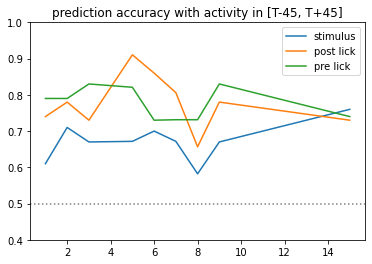

In [868]:
plt.plot(valid_days, all_acc[0], label='stimulus')
plt.plot(valid_days, all_acc[1], label='post lick')
plt.plot(valid_days, all_acc[2], label='pre lick')
plt.axhline(0.5, linestyle=':', color='grey')
plt.ylim([0.4,1])
plt.legend()
plt.title('prediction accuracy with activity in [T-45, T+45]')

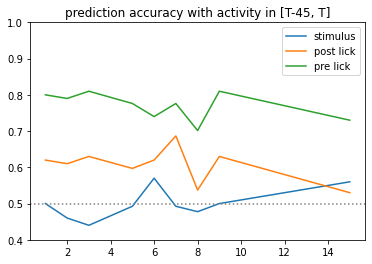

In [869]:
plt.title('prediction accuracy with activity in [T-45, T]')
plt.plot(valid_days, pre_acc[0], label='stimulus')
plt.plot(valid_days, pre_acc[1], label='post lick')
plt.plot(valid_days, pre_acc[2], label='pre lick')
plt.axhline(0.5, linestyle=':', color='grey')
plt.ylim([0.4,1])
plt.legend()

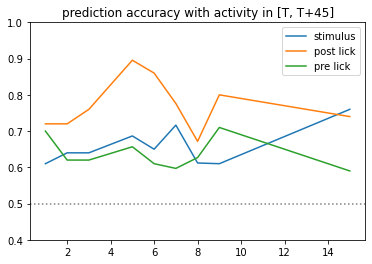

In [870]:
plt.title('prediction accuracy with activity in [T, T+45]')
plt.plot(valid_days, post_acc[0], label='stimulus')
plt.plot(valid_days, post_acc[1], label='post lick')
plt.plot(valid_days, post_acc[2], label='pre lick')
plt.axhline(0.5, linestyle=':', color='grey')
plt.ylim([0.4,1])
plt.legend()

## acc on pb 

Text(0.5, 1.0, 'prediction accuracy with activity in [T-45, T+45] on probe trials')

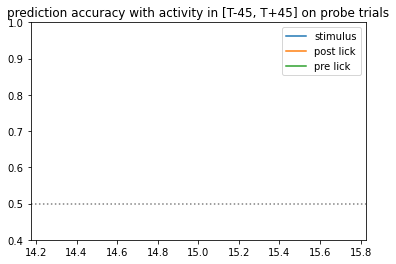

In [871]:
pb_ind = np.where(daily_cues > 2)[0]
rl_ind = np.where(daily_cues < 3)[0]
if len(pb_ind) > 0:
    model.fit(spks[rl_ind], stim[rl_ind])
    te_pred = model.predict(spks[pb_ind])
    acc = np.sum(te_pred == stim[pb_ind]) / len(pb_ind)
    pb_acc[0, i] = acc

    if (np.mean(postlick) == 0) or (np.mean(postlick) == 1):
        acc = 0.5
    else:
        model.fit(spks[rl_ind], postlick[rl_ind])
        te_pred = model.predict(spks[pb_ind])
        acc = np.sum(te_pred == postlick[pb_ind]) / len(pb_ind)
    pb_acc[1, i] = acc

    if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
        acc = 0.5
    else:
        model.fit(spks[rl_ind], prelick[rl_ind])
        te_pred = model.predict(spks[pb_ind])
        acc = np.sum(te_pred == prelick[pb_ind]) / len(pb_ind)
    pb_acc[2, i] = acc
    
valid_days = np.array(valid_days)
idx = np.where(pb_acc[0] > 0)[0]
plt.plot(valid_days[idx], pb_acc[0, idx], label='stimulus')
idx = np.where(pb_acc[1] > 0)[0]
plt.plot(valid_days[idx], pb_acc[1, idx], label='post lick')
idx = np.where(pb_acc[2] > 0)[0]
plt.plot(valid_days[idx], pb_acc[2, idx], label='pre lick')

plt.axhline(0.5, linestyle=':', color='grey')
plt.ylim([0.4,1])
plt.legend()
plt.title('prediction accuracy with activity in [T-45, T+45] on probe trials')

# use PCs to predict 

## predict stimulus

In [ ]:
print(daily_responses.shape)
spks = daily_responses.reshape(daily_responses.shape[0], -1)
print(spks.shape)

In [ ]:
NT = len(daily_cues) # number of trials
stim = np.ones(daily_cues.shape)
stim[np.where(daily_cues==2)] = 0 
stim[np.where(daily_cues==4)] = 0
stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

In [ ]:
nc_list = [1, 2, 5, 10, 20, 50, 100, len(spks)]
accs = []
for nc in nc_list:
    print('number of components: ', nc)
    pca = PCA(n_components=nc)
    pca_spks = pca.fit_transform(spks)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(pca_spks[itrain], stim[itrain])
    te_pred = model.predict(pca_spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('accuracy predicting stimulus identity on test set: ', acc)
    accs.append(acc)
    tr_pred = model.predict(pca_spks[itrain])
    acc = np.sum(tr_pred == stim[itrain]) / len(itrain)
    print('accuracy predicting stimulus identity on train set: ', acc)

In [ ]:
plt.plot(nc_list, accs)
plt.plot(nc_list, np.ones(len(accs)) * all_acc[0, 0])

## postlick

In [70]:
postlick = np.ones(daily_outcomes.shape)
postlick[np.where(daily_outcomes==2)] = 0 
postlick[np.where(daily_outcomes==4)] = 0
postlick = np.multiply((postlick == 1), 1)  # lick: 1, nolick: 0

In [71]:
nc_list = [1, 2, 5, 10, 20, 50, 100, len(spks)]
accs = []
for nc in nc_list:
    print('number of components: ', nc)
    pca = PCA(n_components=nc)
    pca_spks = pca.fit_transform(spks)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(pca_spks[itrain], postlick[itrain])
    te_pred = model.predict(pca_spks[itest])
    acc = np.sum(te_pred == postlick[itest]) / len(itest)
    print('accuracy predicting postlick on test set: ', acc)
    accs.append(acc)
    tr_pred = model.predict(pca_spks[itrain])
    acc = np.sum(tr_pred == postlick[itrain]) / len(itrain)
    print('accuracy predicting postlick on train set: ', acc)

number of components:  1
accuracy predicting postlick on test set:  0.64
accuracy predicting postlick on train set:  0.61
number of components:  2
accuracy predicting postlick on test set:  0.64
accuracy predicting postlick on train set:  0.655
number of components:  5
accuracy predicting postlick on test set:  0.65
accuracy predicting postlick on train set:  0.67
number of components:  10
accuracy predicting postlick on test set:  0.75
accuracy predicting postlick on train set:  0.745
number of components:  20
accuracy predicting postlick on test set:  0.75
accuracy predicting postlick on train set:  0.75
number of components:  50
accuracy predicting postlick on test set:  0.74
accuracy predicting postlick on train set:  0.77
number of components:  100
accuracy predicting postlick on test set:  0.71
accuracy predicting postlick on train set:  0.965
number of components:  300
accuracy predicting postlick on test set:  0.7
accuracy predicting postlick on train set:  1.0


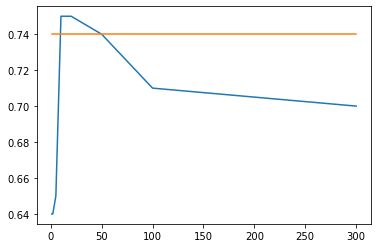

In [72]:
plt.plot(nc_list, accs)
plt.plot(nc_list, np.ones(len(accs)) * all_acc[1, 0])

## prelick

In [75]:
prelick = (np.sum(daily_alllicks[:, :30], axis=1) > 0)
prelick = np.multiply((prelick == 1), 1)

nc_list = [1, 2, 5, 10, 20, 50, 100, len(spks)]
accs = []
for nc in nc_list:
    print('number of components: ', nc)
    pca = PCA(n_components=nc)
    pca_spks = pca.fit_transform(spks)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(pca_spks[itrain], prelick[itrain])
    te_pred = model.predict(pca_spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    print('accuracy predicting prelick on test set: ', acc)
    accs.append(acc)
    tr_pred = model.predict(pca_spks[itrain])
    acc = np.sum(tr_pred == prelick[itrain]) / len(itrain)
    print('accuracy predicting pretlick on train set: ', acc)

number of components:  1
accuracy predicting prelick on test set:  0.64
accuracy predicting pretlick on train set:  0.645
number of components:  2
accuracy predicting prelick on test set:  0.64
accuracy predicting pretlick on train set:  0.72
number of components:  5
accuracy predicting prelick on test set:  0.77
accuracy predicting pretlick on train set:  0.785
number of components:  10
accuracy predicting prelick on test set:  0.74
accuracy predicting pretlick on train set:  0.805
number of components:  20
accuracy predicting prelick on test set:  0.77
accuracy predicting pretlick on train set:  0.82
number of components:  50
accuracy predicting prelick on test set:  0.77
accuracy predicting pretlick on train set:  0.87
number of components:  100
accuracy predicting prelick on test set:  0.78
accuracy predicting pretlick on train set:  0.98
number of components:  300
accuracy predicting prelick on test set:  0.78
accuracy predicting pretlick on train set:  1.0


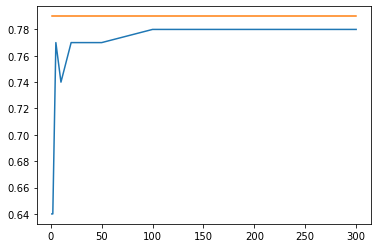

In [76]:
plt.plot(nc_list, accs)
plt.plot(nc_list, np.ones(len(accs)) * all_acc[2, 0])

## all days

In [872]:
pca_accs_stim = []
pca_accs_postlick = []
pca_accs_prelick = []
all_nc_lists = []
pre_window=45
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_firstlicks = np.hstack(daily_firstlicks)
        daily_alllicks = np.vstack(daily_alllicks)
    
        
    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]

    NT = len(daily_cues) # number of trials
    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)
    
    # nc_list = [1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100]
    nc_list = [1, 2, 3, 5, 10, 15, 20]
    accs_stim = []
    accs_post = []
    accs_pre = []
    model = LogisticRegression(solver='liblinear', random_state=0)
    postlick = np.ones(daily_outcomes.shape)
    postlick[np.where(daily_outcomes==2)] = 0 
    postlick[np.where(daily_outcomes==4)] = 0
    postlick = np.multiply((postlick == 1), 1)  
    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    for nc in nc_list:
        # print('number of components: ', nc)
        pca = PCA(n_components=nc)
        pca_spks = pca.fit_transform(spks)
        if (np.mean(postlick) == 0) or (np.mean(postlick) == 1):
            acc = 0.5
        else:
            model.fit(pca_spks[itrain], postlick[itrain])
            te_pred = model.predict(pca_spks[itest])
            acc = np.sum(te_pred == postlick[itest]) / len(itest)
        accs_post.append(acc)
        if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
            acc = 0.5
        else:
            model.fit(pca_spks[itrain], prelick[itrain])
            te_pred = model.predict(pca_spks[itest])
            acc = np.sum(te_pred == prelick[itest]) / len(itest)
        accs_pre.append(acc)
        model.fit(pca_spks[itrain], stim[itrain])
        te_pred = model.predict(pca_spks[itest])
        acc = np.sum(te_pred == stim[itest]) / len(itest)
        accs_stim.append(acc)
    pca_accs_stim.append(accs_stim)
    pca_accs_postlick.append(accs_post)
    pca_accs_prelick.append(accs_pre)
    all_nc_lists.append(nc_list)


-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 15750)
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 12690)
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
(300, 18450)
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
(200, 14220)
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
(300, 15210)
-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
(200, 15390)
-------------------day 8---------------------
******** predict with activities in [T-45, T+45]
(200, 16830)
-------------------day 9---------------------
******** predict with activities in [T-45, T+45]
(300, 17820)
-------------------day 15---------------------
******** predict with activities in [T-45, T+45]
(300, 16200)


Text(0.5, 1.0, 'stimuli, max acc: 0.76')

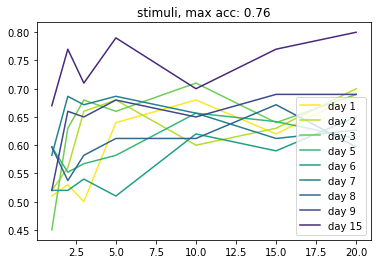

In [874]:
cmap = plt.cm.get_cmap('viridis_r')
for iday, day in enumerate(valid_days):
    plt.plot(nc_list, pca_accs_stim[iday], label='day {}'.format(day), color=cmap(iday/len(valid_days)))
plt.plot()
plt.legend()
plt.title('stimuli, max acc: {}'.format(np.max(all_acc[0])))

Text(0.5, 1.0, 'postlick, max acc: 0.9104477611940298')

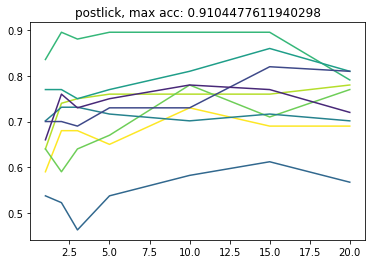

In [875]:
cmap = plt.cm.get_cmap('viridis_r')
for iday, day in enumerate(valid_days):
    plt.plot(nc_list, pca_accs_postlick[iday], label='day {}'.format(day), color=cmap(iday/len(valid_days)))
plt.plot()
# plt.legend()
plt.title('postlick, max acc: {}'.format(np.max(all_acc[1])))

Text(0.5, 1.0, 'prelick, max acc: 0.9253731343283582')

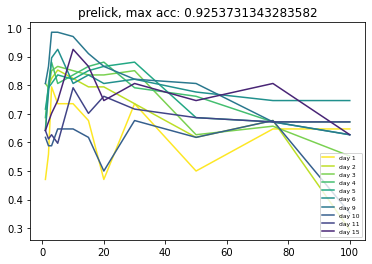

In [81]:
cmap = plt.cm.get_cmap('viridis_r')
for iday, day in enumerate(valid_days):
    plt.plot(nc_list, pca_accs_prelick[iday], label='day {}'.format(day), color=cmap(iday/len(valid_days)))
plt.plot()
plt.legend(loc=4, fontsize=6)
plt.title('prelick, max acc: {}'.format(np.max(all_acc[2])))

Text(0.5, 1.0, 'maximum accuracy with 1-20 PCs, jl009')

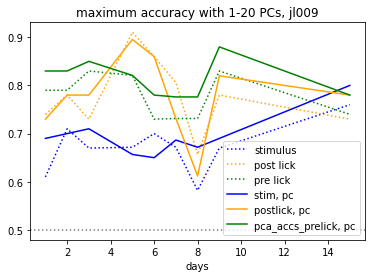

In [876]:
plt.plot(valid_days, all_acc[0], label='stimulus', linestyle=':', color='blue')
plt.plot(valid_days, all_acc[1], label='post lick', linestyle=':', color='orange')
plt.plot(valid_days, all_acc[2], label='pre lick', linestyle=':', color='green')
plt.axhline(0.5, linestyle=':', color='grey')

pca_accs_stim = np.array(pca_accs_stim)
pca_accs_postlick = np.array(pca_accs_postlick)
pca_accs_prelick = np.array(pca_accs_prelick)

plt.plot(valid_days, np.max(pca_accs_stim, axis=1), label='stim, pc', color='blue')
plt.plot(valid_days, np.max(pca_accs_postlick, axis=1), label='postlick, pc', color='orange')
plt.plot(valid_days, np.max(pca_accs_prelick, axis=1), label='pca_accs_prelick, pc', color='green')

plt.legend()
plt.xlabel('days')
plt.title('maximum accuracy with 1-20 PCs, {}'.format(mouse_name))

Text(0.5, 0, 'days')

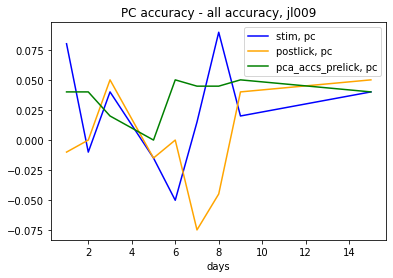

In [877]:
plt.plot(valid_days, np.max(pca_accs_stim, axis=1) - all_acc[0], label='stim, pc', color='blue')
plt.plot(valid_days, np.max(pca_accs_postlick, axis=1)-all_acc[1], label='postlick, pc', color='orange')
plt.plot(valid_days, np.max(pca_accs_prelick, axis=1)-all_acc[2], label='pca_accs_prelick, pc', color='green')
plt.title('PC accuracy - all accuracy, {}'.format(mouse_name))
plt.legend()
plt.xlabel('days')

# decoding stimuli id and behavior performance

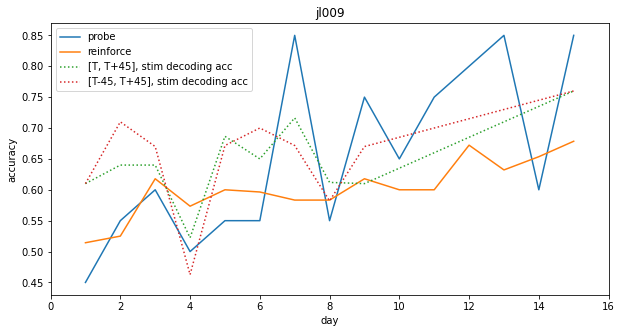

In [16]:
beh_data_path = "{}:/Jenni/{}/behavior/justbehavior".format(disks[mouse_id], mouse_name)
fnames = [_ for _ in os.listdir(beh_data_path) if _.endswith('txt')]

from tkinter import Tcl
fnames = Tcl().call('lsort', '-dict', fnames)

nBlocks = len(fnames)
pbRes = np.zeros((4, nBlocks))
rlRes = np.zeros((4, nBlocks))
nPB = np.zeros(nBlocks)
days = np.zeros(nBlocks)
for i in range(nBlocks):
    tmp = fnames[i].split('_')[-1]
    days[i] = int(tmp.split('v')[0])
    fpath = os.path.join(beh_data_path, fnames[i])
    bmat = load_behavior_txt(fpath)
    behavior = bmat[:, 12].reshape(-1).astype(int)
    outcome = bmat[:, 3].reshape(-1).astype(int)
    nPB[i] = np.sum(behavior==0)
    if nPB[i] > 0:
        pbIdx = np.where(behavior==0)
        pbOutcome = outcome[pbIdx]
        for j in range(4):
            pbRes[j, i] = np.sum(pbOutcome == j+1) / nPB[i]

    rlIdx = np.where(behavior==1)
    rlOutcome = outcome[rlIdx]
    for j in range(4):
        rlRes[j, i] = np.sum(rlOutcome == j+1) / (100 - nPB[i])
days = days.astype('int')

ptrue = pbRes[0] + pbRes[3]
rtrue = rlRes[0] + rlRes[3]

daymax = days.max()
dptrue = np.zeros(daymax)
drtrue = np.zeros(daymax)
for d in range(daymax):
    dind = np.where(days==(d+1))
    dnPB = nPB[dind]
    pbind = np.where(dnPB == 20)[0]
    # if has probe trial in a day
    if pbind.shape[0] > 0:
        tmp = ptrue[dind]
        dptrue[d] = np.average(tmp[pbind], weights=dnPB[pbind])
    weights = 100 - dnPB
    drtrue[d] = np.average(rtrue[dind], weights=weights)

colors = np.array(["green", "blue"])
x = np.arange(1, daymax+1)
plt.figure(figsize=(10, 5))
dp_nonzero = np.where(dptrue>0)
dr_nonzero = np.where(drtrue>0)
plt.plot(x[dp_nonzero], dptrue[dp_nonzero], label='probe', color='red', linestyle=':')
plt.plot(x[dr_nonzero], drtrue[dr_nonzero], label='reinforce', color='black', linestyle=':')
plt.xlim([0, daymax+1])
plt.plot(valid_days, post_acc[0], label='[T, T+45], stim decoding acc', linestyle=':')
plt.plot(valid_days, all_acc[0], label='[T-45, T+45], stim decoding acc', linestyle=':')
# plt.plot(x, dptrue, color=colors[0], alpha=0.5, label='PB')
# plt.plot(x, drtrue, color=colors[1], alpha=0.5, label='RL')

# valid_days = np.array(valid_days)
# idx = np.where(pb_acc[0] > 0)[0]
# plt.plot(valid_days[idx], pb_acc[0, idx], label='pb, stimulus', color='red')
# idx = np.where(pb_acc[1] > 0)[0]
# plt.plot(valid_days[idx], pb_acc[1, idx], label='pb, post lick')
# idx = np.where(pb_acc[2] > 0)[0]
# plt.plot(valid_days[idx], pb_acc[2, idx], label='pb, pre lick')

plt.title('{}'.format(mouse_name))
# plt.xticks(x, days)
plt.xlabel('day')
plt.ylabel('accuracy')
plt.legend()

# rastermap

In [5]:
day = 1
iblocks = daily_blocks(data, day)
if len(iblocks)>0:
    daily_cues = []
    daily_outcomes = []
    daily_responses = []
    daily_firstlicks = []
    daily_alllicks = []
    for i in iblocks:
        block = data[0, i]
        # normalize doesn't have much effect on the result, so set it to False
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[30, 45], normalize=True, dff=False)
        daily_cues.append(cues)
        daily_outcomes.append(outcomes)
        daily_responses.append(stim_resp)
        daily_firstlicks.append(firstlicks)
        daily_alllicks.append(alllicks)

    daily_cues = np.hstack(daily_cues)
    daily_outcomes = np.hstack(daily_outcomes)
    daily_responses = np.vstack(daily_responses)
    daily_firstlicks = np.hstack(daily_firstlicks)
    daily_alllicks = np.vstack(daily_alllicks)
    print('day {} spk shape: {}'.format(day, daily_responses.shape))
    print('day {} behavior shape: {}'.format(day, daily_outcomes.shape))
    print('day {} alllick shape: {}'.format(day, daily_alllicks.shape))
    print('day {} outcome shape: {}'.format(day, daily_outcomes.shape)) # 1234 -> Hit Miss FA CR
    print('day {} cue shape: {}'.format(day, daily_cues.shape)) # 1 target ; 2 foil ; 3 target(probe)

day 1 spk shape: (300, 175, 75)
day 1 behavior shape: (300,)
day 1 alllick shape: (300, 75)
day 1 outcome shape: (300,)
day 1 cue shape: (300,)


In [3]:
from rastermap import Rastermap

model = Rastermap(n_components=1, n_X=30, nPC=200, init='pca')

In [92]:
sp = daily_responses.transpose(1, 0, 2)
sp = sp.reshape(len(sp), -1)
print(sp.shape)
plt.imshow(sp[model.isort1, :])

(175, 27000)


In [94]:
model.fit(sp)

nmin 175
0.015003681182861328
0.5621285438537598
0.7551746368408203
0.7561733722686768
(28, 30)
(60,)
1.0
time; iteration;  explained PC variance
0.00s     0        0.0139      2
0.02s    10        0.0389      4
0.05s    20        0.0655      8
0.12s    30        0.1194      18
0.14s    40        0.1666      28
0.21s    50        0.1668      28
0.23s   final      0.1670
0.23s upsampled    0.1670


Text(0.5, 0.98, 'Miss')

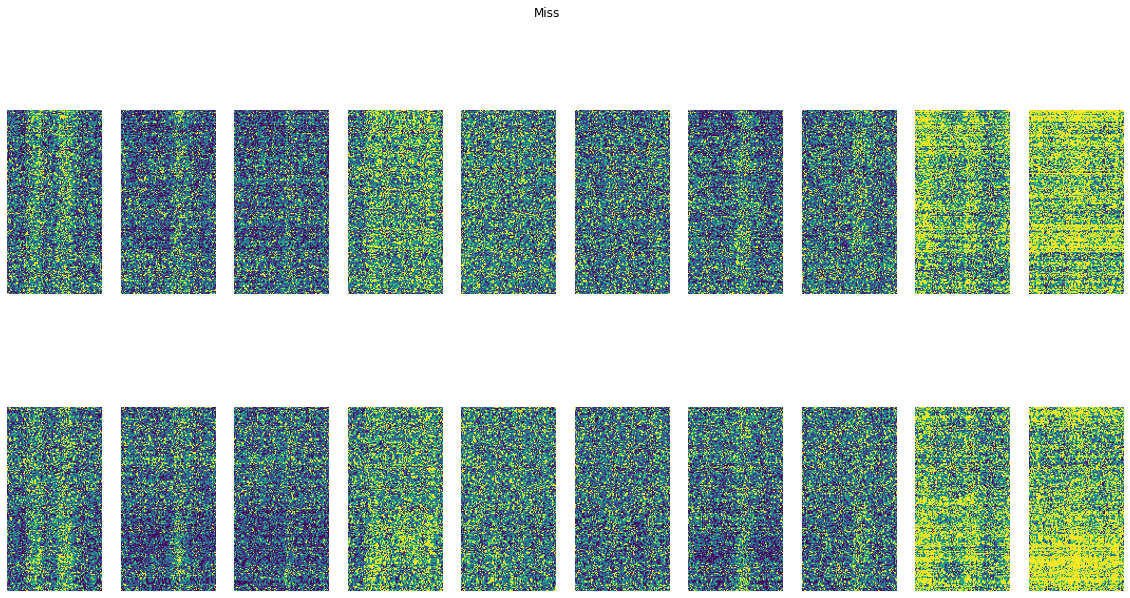

In [119]:
# attributes: embedding, u, s, v, isort1
ioutcome = 2
idx = np.where(daily_outcomes == ioutcome)[0]
plt.figure(figsize=(20, 10))
idx = np.random.choice(idx, 10, replace=False)
for i in range(10):
    plt.subplot(2, 10, 10+i+1)
    plt.imshow(daily_responses[idx[i], model.isort, :], cmap='viridis', vmin=-1, vmax=1)
    plt.axis('off')
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(daily_responses[idx[i],:, :], cmap='viridis', vmin=-1, vmax=1)
    plt.axis('off')
plt.suptitle(outcome_list[ioutcome-1])

In [6]:
from utils import daily_blocks, block_stim_evoke_response
day = 1
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for i in iblocks:
            block = data[0, i]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[30, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_firstlicks = np.hstack(daily_firstlicks)
        daily_alllicks = np.vstack(daily_alllicks)

        print('day {} spk shape: {}'.format(day, daily_responses.shape))
        print('day {} behavior shape: {}'.format(day, daily_outcomes.shape))
        print('day {} alllick shape: {}'.format(day, daily_alllicks.shape))
        
        NN = daily_responses.shape[1]
        sp = daily_responses.transpose(1, 0, 2)
        sp = sp.reshape(len(sp), -1)
        model.fit(sp)
        isort = model.isort
        
        outcome_index = 1
        for outcome_index in range(1,5):
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = daily_responses[ioutcome]
            lick = daily_alllicks[ioutcome].reshape(-1)
            resp = resp.transpose(1, 0, 2)
            resp = resp.reshape(NN, -1)
            resp = resp[isort]
            NT = resp.shape[-1]
            cue = np.zeros(NT)
            out = np.zeros(NT)
            flick = np.zeros(NT)
            for k, v in enumerate(ioutcome):
                cue[30+75*k] = daily_cues[v]
                out[30+75*k] = daily_outcomes[v]
                if daily_firstlicks[k] >= 0:
                    flick[75*k + int(daily_firstlicks[v])] = 1
                resp[:, (75*k-1):(75*k+1)] = 0
            figw = max(int(len(ioutcome)*10/15), 20)
            f, (a0, a1, a2, a3, a4) = plt.subplots(5, 1, gridspec_kw={'height_ratios': [3, 1, 2, 1, 1]}, figsize=(figw,10))
            f.set_facecolor("white")
            im1 = a0.imshow(resp, vmin=-1, vmax=1, cmap='bwr', aspect='auto') # magma
            a0.set_xlabel('frames')
            a0.set_ylabel('neuron')
            x = np.arange(NT)
            y = resp.mean(axis=0)
            tmin = 0
            tmax = NT
            a1.plot(x, lick, label='all lick')
            a1.set_xlim([tmin, tmax])
            a1.plot(x, flick, label='first lick')
            a1.legend(loc=1)
            a2.plot(x, y)
            idx = np.where(cue > 0)[0]
            a2.scatter(x[idx], y[idx], c='red', label='cue onset')
            a2.legend(loc=1)
            idx = np.where(flick>0)
            # a2.scatter(x[idx], y[idx], c='orange', label='first lick')
            a2.legend(loc=1)
            for k, v in enumerate(ioutcome):
                a1.axvline(75*k, alpha=0.2, linestyle='--')
            a2.set_xlim([tmin, tmax])
            a2.set_title('average activity')
            a3.plot(np.arange(NT), cue)
            a3.set_xlim([tmin, tmax])
            a3.set_ylim([0, 4])
            a3.set_title('cue')
            a4.plot(np.arange(NT), out)
            a4.set_xlim([tmin, tmax])
            a4.set_title('outcome')
            a4.set_ylim([0, 4])
            a0.set_title('day {}'.format(day))
#             a4.plot(np.arange(NT), flick)
#             a4.set_xlim([tmin, tmax])
#             a4.set_title('first lick')
            plt.tight_layout()
            fig_save_path = os.path.join('figures', 'stim-evoke-response_{}_day-{}_{}_rmsorted'.format(mouse_name, day, outcome_list[outcome_index-1]))
            plt.savefig(fig_save_path, dpi=100)
            plt.close()

day 1 spk shape: (300, 175, 75)
day 1 behavior shape: (300,)
day 1 alllick shape: (300, 75)
nmin 175
0.011002779006958008
2.3025290966033936
2.4365603923797607
2.4385619163513184
(28, 30)
(60,)
1.0
time; iteration;  explained PC variance
0.63s     0        0.0142      2
0.66s    10        0.0394      4
0.70s    20        0.0662      8
0.73s    30        0.1197      18
0.80s    40        0.1675      28
0.83s    50        0.1685      28
0.90s   final      0.1685
0.90s upsampled    0.1685
day 2 spk shape: (300, 141, 75)
day 2 behavior shape: (300,)
day 2 alllick shape: (300, 75)
nmin 141
0.011002302169799805
0.6141402721405029
0.7401695251464844
0.7411701679229736
(28, 30)
(60,)
1.0
time; iteration;  explained PC variance
0.00s     0        0.0153      2
0.03s    10        0.0378      4
0.06s    20        0.0661      8
0.13s    30        0.1282      18
0.16s    40        0.1845      28
0.22s    50        0.1847      28
0.24s   final      0.1848
0.24s upsampled    0.1848
day 3 spk shape: (

# Weight analysis

In [20]:
pre_window = 45
print('-------------------day {}---------------------'.format(day))
print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
iblocks = daily_blocks(data, day)
if len(iblocks)>0:
    daily_cues = []
    daily_outcomes = []
    daily_responses = []
    daily_firstlicks = []
    daily_alllicks = []
    for j in iblocks:
        block = data[0, j]
        # normalize doesn't have much effect on the result, so set it to False
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
        daily_cues.append(cues)
        daily_outcomes.append(outcomes)
        daily_responses.append(stim_resp)
        daily_firstlicks.append(firstlicks)
        daily_alllicks.append(alllicks)

    daily_cues = np.hstack(daily_cues)
    daily_outcomes = np.hstack(daily_outcomes)
    daily_responses = np.vstack(daily_responses)
    daily_alllicks = np.vstack(daily_alllicks)

nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
inotnan = np.where(nanflag==0)
daily_responses = daily_responses[inotnan]
daily_cues = daily_cues[inotnan]
daily_outcomes = daily_outcomes[inotnan]
daily_alllicks = daily_alllicks[inotnan]
NT, NA, NF = daily_responses.shape
print(daily_responses.shape)

stim = np.ones(daily_cues.shape)
stim[np.where(daily_cues==2)] = 0 
stim[np.where(daily_cues==4)] = 0
stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

spks = daily_responses.reshape(daily_responses.shape[0], -1)
print(spks.shape)

random.seed(0)
np.random.seed(0)
itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
itest = np.setxor1d(np.arange(NT), itrain)


-------------------day 11---------------------
******** predict with activities in [T-45, T+45]
(200, 348, 90)
(200, 31320)


accuracy predicting stimulus identity on test set:  0.7313432835820896
(1, 31320)
(348, 90)


Text(0.5, 1.0, 'stimuli classifier weight, day11, fz017')

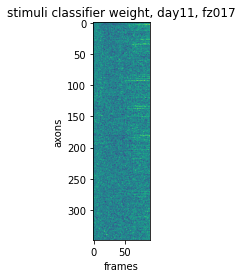

In [21]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(spks[itrain], stim[itrain])
te_pred = model.predict(spks[itest])
acc = np.sum(te_pred == stim[itest]) / len(itest)
print('accuracy predicting stimulus identity on test set: ', acc)
print(model.coef_.shape)
stim_weights = model.coef_.reshape((NA, NF))
print(stim_weights.shape)
plt.imshow(stim_weights)
plt.xlabel('frames')
plt.ylabel('axons')
plt.title('stimuli classifier weight, day{}, {}'.format(day, mouse_name))

In [25]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(spks[itrain], stim[itrain])
te_pred = model.predict(spks[itest])
acc = np.sum(te_pred == stim[itest]) / len(itest)
print('accuracy predicting stimulus identity on test set: ', acc)
print(model.coef_.shape)
stim_weights = model.coef_.reshape((NA, NF))
print(stim_weights.shape)
prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
prelick = np.multiply((prelick == 1), 1)
# if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
#     acc = 0.5
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(spks[itrain], prelick[itrain])
te_pred = model.predict(spks[itest])
acc = np.sum(te_pred == prelick[itest]) / len(itest)
prelick_weights = model.coef_.reshape((NA, NF))
print('accuracy predicting prelick on test set: ', acc)

idx, non_idx = important_axons(stim_weights, proportion=0.1)

accuracy predicting stimulus identity on test set:  0.7313432835820896
(1, 31320)
(348, 90)
accuracy predicting prelick on test set:  0.7910447761194029


nmin 34
0.0019996166229248047
0.05301094055175781
0.0600132942199707
0.06201338768005371
(28, 30)
(60,)
1.0
time; iteration;  explained PC variance
0.00s     0        0.0870      2
0.02s    10        0.1683      4
0.04s    20        0.2871      8
0.06s    30        0.5158      18
0.08s    40        0.6949      28
0.10s    50        0.6950      28
0.12s   final      0.6951
0.12s upsampled    0.6951


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_1808/917875493.py:22: RuntimeWarning: Mean of empty slice.
  resp = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


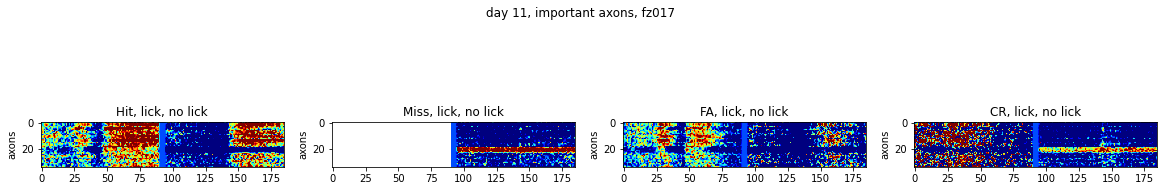

In [26]:
from utils import daily_blocks, block_stim_evoke_response
from rastermap import Rastermap
model = Rastermap(n_components=1, n_X=30, nPC=200, init='pca')
im_spks = daily_responses[:, idx, :]
NN = im_spks.shape[1]
sp = im_spks.transpose(1, 0, 2)
sp = sp.reshape(len(sp), -1)
model.fit(sp)
isort = model.isort

outcome_index = 1
plt.figure(figsize=(20,4))
for outcome_index in range(1,5):
    all_resp = np.zeros((NN, 90*2+5))
    ioutcome = np.where(daily_outcomes == outcome_index)[0]
    oresp = im_spks[ioutcome]

    lick = daily_alllicks[ioutcome] 
    n_prelicks = np.sum(lick[:, 15:30], axis=1)
    lick_idx = np.where(n_prelicks != 0)[0] # with prelick
    resp = oresp[lick_idx]
    resp = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)
    

    # isort = np.argsort(resp[:, 30:].sum(axis=1)) # sort by pre lick frequency
    all_resp[:, :90] = resp[isort]

    nolick_idx = np.where(n_prelicks == 0)[0] # without prelick
    resp = oresp[nolick_idx]
    resp = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)
    all_resp[:, (90+5):] = resp[isort]

    plt.subplot(1,4,outcome_index)
    plt.imshow(all_resp, cmap='jet', vmin=-0.1, vmax=0.4)
    plt.ylabel('axons')
    # plt.colorbar()
    # plt.plot(x, all_resp, label='all', color='black', linestyle='--')
    plt.title('{}, lick, no lick'.format(outcome_list[outcome_index-1]))
plt.suptitle('day {}, important axons, {}'.format(day, mouse_name))
plt.show()
    # fig_save_path = os.path.join('figures',  'stim-evoke-response-prelickornot_{}_day-{}'.format(mouse_name, day))
    # plt.savefig(fig_save_path, dpi=100)
    # plt.close()

In [27]:
print(im_spks.shape)

(200, 34, 90)


nmin 200
0.014003276824951172
2.455564498901367
2.5045759677886963
2.5055763721466064
(28, 30)
(60,)
1.0
time; iteration;  explained PC variance
0.01s     0        0.0103      2
0.06s    10        0.0293      4
0.08s    20        0.0509      8
0.11s    30        0.0907      18
0.14s    40        0.1275      28
0.17s    50        0.1281      28
0.20s   final      0.1283
0.20s upsampled    0.1283


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_1808/413133918.py:22: RuntimeWarning: Mean of empty slice.
  resp = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


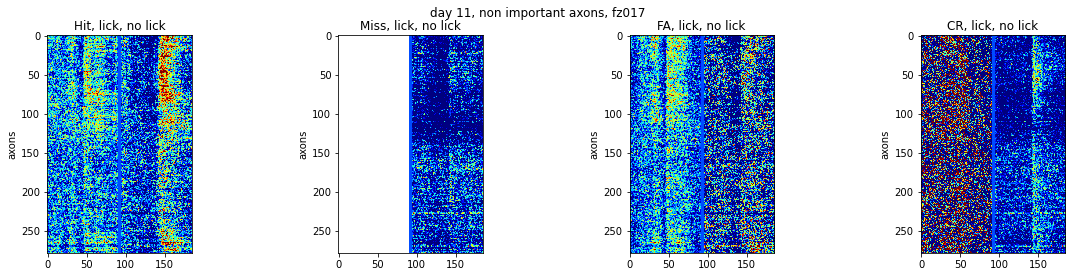

In [24]:
from utils import daily_blocks, block_stim_evoke_response
from rastermap import Rastermap
model = Rastermap(n_components=1, n_X=30, nPC=200, init='pca')
im_spks = daily_responses[:, non_idx, :]
NN = im_spks.shape[1]
sp = im_spks.transpose(1, 0, 2)
sp = sp.reshape(len(sp), -1)
model.fit(sp)
isort = model.isort

outcome_index = 1
plt.figure(figsize=(20,4))
for outcome_index in range(1,5):
    all_resp = np.zeros((NN, 90*2+5))
    ioutcome = np.where(daily_outcomes == outcome_index)[0]
    oresp = im_spks[ioutcome]

    lick = daily_alllicks[ioutcome] 
    n_prelicks = np.sum(lick[:, 15:30], axis=1)
    lick_idx = np.where(n_prelicks != 0)[0] # with prelick
    resp = oresp[lick_idx]
    resp = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)
    

    # isort = np.argsort(resp[:, 30:].sum(axis=1)) # sort by pre lick frequency
    all_resp[:, :90] = resp[isort]

    nolick_idx = np.where(n_prelicks == 0)[0] # without prelick
    resp = oresp[nolick_idx]
    resp = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)
    all_resp[:, (90+5):] = resp[isort]

    plt.subplot(1,4,outcome_index)
    plt.imshow(all_resp, cmap='jet', vmin=-0.1, vmax=0.4)
    plt.ylabel('axons')
    # plt.colorbar()
    # plt.plot(x, all_resp, label='all', color='black', linestyle='--')
    plt.title('{}, lick, no lick'.format(outcome_list[outcome_index-1]))
plt.suptitle('day {}, non important axons, {}'.format(day, mouse_name))
plt.show()
    # fig_save_path = os.path.join('figures',  'stim-evoke-response-prelickornot_{}_day-{}'.format(mouse_name, day))
    # plt.savefig(fig_save_path, dpi=100)
    # plt.close()

## find axons

accuracy predicting stimulus identity on test set:  0.76
(1, 16200)
(180, 90)
accuracy predicting prelick on test set:  0.74
[important] accuracy predicting stimulus identity on test set:  0.77
[non important] accuracy predicting stimulus identity on test set:  0.6
[important]accuracy predicting prelick on test set:  0.72
[non important] accuracy predicting prelick on test set:  0.54


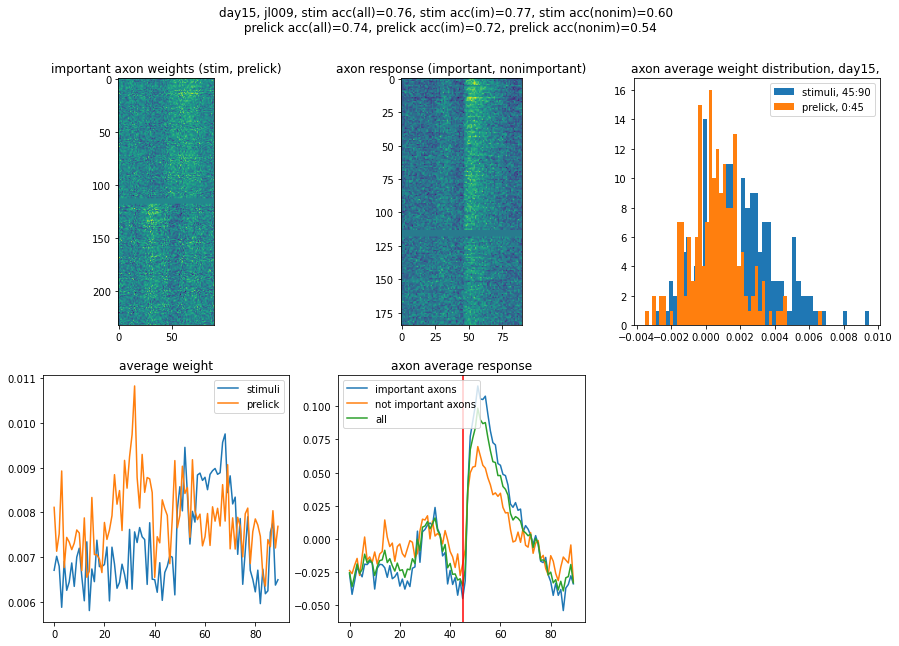

In [573]:
plt.figure(figsize=(15, 10))

accs = []

model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(spks[itrain], stim[itrain])
te_pred = model.predict(spks[itest])
acc = np.sum(te_pred == stim[itest]) / len(itest)
print('accuracy predicting stimulus identity on test set: ', acc)
accs.append(acc)
print(model.coef_.shape)
stim_weights = model.coef_.reshape((NA, NF))
print(stim_weights.shape)
prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
prelick = np.multiply((prelick == 1), 1)
# if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
#     acc = 0.5
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(spks[itrain], prelick[itrain])
te_pred = model.predict(spks[itest])
acc = np.sum(te_pred == prelick[itest]) / len(itest)
prelick_weights = model.coef_.reshape((NA, NF))
print('accuracy predicting prelick on test set: ', acc)
accs.append(acc)

thresh = 0.001
axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
axons_contribution_prelick = np.mean(prelick_weights[:, :45], axis=1)
idx = np.where(axons_contribution > thresh)[0]
non_idx = np.where(axons_contribution <= thresh)[0]
spks = spks.reshape(NT, NA, NF)
NNA = len(idx)

axon_spks = spks[:, idx, :]
axon_spks = axon_spks.reshape(NT, -1)
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(axon_spks[itrain], stim[itrain])
te_pred = model.predict(axon_spks[itest])
acc = np.sum(te_pred == stim[itest]) / len(itest)
stim_weights = model.coef_.reshape((NNA, NF))
print('[important] accuracy predicting stimulus identity on test set: ', acc)
accs.append(acc)
non_axon_spks = spks[:, non_idx, :]
non_axon_spks = non_axon_spks.reshape(NT, -1)
model.fit(non_axon_spks[itrain], stim[itrain])
te_pred = model.predict(non_axon_spks[itest])
acc = np.sum(te_pred == stim[itest]) / len(itest)
print('[non important] accuracy predicting stimulus identity on test set: ', acc)
accs.append(acc)

model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(axon_spks[itrain], prelick[itrain])
te_pred = model.predict(axon_spks[itest])
acc = np.sum(te_pred == prelick[itest]) / len(itest)
prelick_weights = model.coef_.reshape((NNA, NF))
print('[important]accuracy predicting prelick on test set: ', acc)
accs.append(acc)
model.fit(non_axon_spks[itrain], prelick[itrain])
te_pred = model.predict(non_axon_spks[itest])
acc = np.sum(te_pred == prelick[itest]) / len(itest)
print('[non important] accuracy predicting prelick on test set: ', acc)
accs.append(acc)


# idx = np.where(axons_contribution > thresh)[0]
# ng_idx = np.where(axons_contribution < -thresh)[0]
# non_idx = np.where(np.logical_and(-thresh< axons_contribution, axons_contribution <= thresh))[0]
plt.subplot(2,3,2)
resp_show = np.zeros((NA+5, NF))
resp_show[:len(idx), :] = np.mean(daily_responses[:, idx, :], axis=0)
resp_show[(len(idx)+5):, :] = np.mean(daily_responses[:, non_idx, :], axis=0)
plt.imshow(resp_show)
plt.title('axon response (important, nonimportant)')

plt.subplot(2,3,3)
plt.hist(axons_contribution, bins=50, label='stimuli, 45:90')
plt.hist(axons_contribution_prelick, bins=50, label='prelick, 0:45')
plt.legend()
plt.title('axon average weight distribution, day{}, '.format(day, mouse_name))

plt.subplot(2,3,5)
plt.plot(np.mean(daily_responses[:, idx, :].reshape(-1, NF), axis=0), label='important axons')
# plt.plot(np.mean(daily_responses[:, ng_idx, :].reshape(-1, NF), axis=0), label='negative important axons')
plt.plot(np.mean(daily_responses[:, non_idx, :].reshape(-1, NF), axis=0), label='not important axons')
plt.plot(np.mean(daily_responses.reshape(-1, NF), axis=0), label='all')
plt.axvline(x=45, color='red')
plt.legend()
plt.title('axon average response')

plt.subplot(2,3,1)
weight_show = np.zeros((2*len(idx)+5, NF))
weight_show[:len(idx), :] = stim_weights
weight_show[(len(idx)+5):, :] = prelick_weights
plt.imshow(weight_show)
plt.title('important axon weights (stim, prelick)')

plt.subplot(2,3,4)
plt.plot(np.arange(NF), np.mean(np.abs(stim_weights), axis=0), label='stimuli')
plt.plot(np.arange(NF), np.mean(np.abs(prelick_weights), axis=0), label='prelick')
plt.legend()
plt.title('average weight')
plt.suptitle('day{}, {}, stim acc(all)={:.2f}, stim acc(im)={:.2f}, stim acc(nonim)={:.2f} \n \
prelick acc(all)={:.2f}, prelick acc(im)={:.2f}, prelick acc(nonim)={:.2f}\
'.format(day, mouse_name, accs[0], accs[2], accs[3], accs[1], accs[4], accs[5] ))
plt.show()

In [551]:
thresh = 0.002
for thresh in [0.0005, 0.001, 0.002,0.003,0.004,0.005]:
    print('########### thresh = {:.6f} ###############'.format(thresh))
    idx = np.where(axons_contribution > thresh)[0]
    non_idx = np.where(xons_contribution <= thresh)[0]
    spks = spks.reshape(NT, NA, NF)
    NNA = len(idx)

    axon_spks = spks[:, idx, :]
    axon_spks = axon_spks.reshape(NT, -1)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(axon_spks[itrain], stim[itrain])
    te_pred = model.predict(axon_spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('[important] accuracy predicting stimulus identity on test set: ', acc)
    non_axon_spks = spks[:, non_idx, :]
    non_axon_spks = non_axon_spks.reshape(NT, -1)
    model.fit(non_axon_spks[itrain], stim[itrain])
    te_pred = model.predict(non_axon_spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('[non important] accuracy predicting stimulus identity on test set: ', acc)
    
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(axon_spks[itrain], prelick[itrain])
    te_pred = model.predict(axon_spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    prelick_weights = model.coef_.reshape((NNA, NF))
    print('[important]accuracy predicting prelick on test set: ', acc)
    model.fit(non_axon_spks[itrain], prelick[itrain])
    te_pred = model.predict(non_axon_spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    print('[non important] accuracy predicting prelick on test set: ', acc)

########### thresh = 0.000500 ###############
[important] accuracy predicting stimulus identity on test set:  0.68
[non important] accuracy predicting stimulus identity on test set:  0.59
[important]accuracy predicting prelick on test set:  0.73
[non important] accuracy predicting prelick on test set:  0.7
########### thresh = 0.001000 ###############
[important] accuracy predicting stimulus identity on test set:  0.67
[non important] accuracy predicting stimulus identity on test set:  0.61
[important]accuracy predicting prelick on test set:  0.75
[non important] accuracy predicting prelick on test set:  0.67
########### thresh = 0.002000 ###############
[important] accuracy predicting stimulus identity on test set:  0.67
[non important] accuracy predicting stimulus identity on test set:  0.63
[important]accuracy predicting prelick on test set:  0.71
[non important] accuracy predicting prelick on test set:  0.73
########### thresh = 0.003000 ###############
[important] accuracy predict

### all

In [899]:
for day in valid_days:
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape
    print(daily_responses.shape)

    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)
    
    
    plt.figure(figsize=(15, 10))

    accs = []

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('accuracy predicting stimulus identity on test set: ', acc)
    accs.append(acc)
    print(model.coef_.shape)
    stim_weights = model.coef_.reshape((NA, NF))
    print(stim_weights.shape)
    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    # if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
    #     acc = 0.5
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], prelick[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    prelick_weights = model.coef_.reshape((NA, NF))
    print('accuracy predicting prelick on test set: ', acc)
    accs.append(acc)
    spks = spks.reshape(NT, NA, NF)

#     thresh = 0.001
#     axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
#     axons_contribution_prelick = np.mean(prelick_weights[:, :45], axis=1)
#     idx = np.where(axons_contribution > thresh)[0]
#     non_idx = np.where(axons_contribution <= thresh)[0]
#     NNA = len(idx)
    axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
    w_sort = np.argsort(axons_contribution)
    NNA = int(NA/5)
    idx = w_sort[-NNA:]
    non_idx = w_sort[:(NA-NNA)]

    axon_spks = spks[:, idx, :]
    axon_spks = axon_spks.reshape(NT, -1)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(axon_spks[itrain], stim[itrain])
    te_pred = model.predict(axon_spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    stim_weights = model.coef_.reshape((NNA, NF))
    print('[important] accuracy predicting stimulus identity on test set: ', acc)
    accs.append(acc)
    non_axon_spks = spks[:, non_idx, :]
    non_axon_spks = non_axon_spks.reshape(NT, -1)
    model.fit(non_axon_spks[itrain], stim[itrain])
    te_pred = model.predict(non_axon_spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('[non important] accuracy predicting stimulus identity on test set: ', acc)
    accs.append(acc)

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(axon_spks[itrain], prelick[itrain])
    te_pred = model.predict(axon_spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    prelick_weights = model.coef_.reshape((NNA, NF))
    print('[important]accuracy predicting prelick on test set: ', acc)
    accs.append(acc)
    model.fit(non_axon_spks[itrain], prelick[itrain])
    te_pred = model.predict(non_axon_spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    print('[non important] accuracy predicting prelick on test set: ', acc)
    accs.append(acc)


    # idx = np.where(axons_contribution > thresh)[0]
    # ng_idx = np.where(axons_contribution < -thresh)[0]
    # non_idx = np.where(np.logical_and(-thresh< axons_contribution, axons_contribution <= thresh))[0]
    plt.subplot(2,3,2)
    resp_show = np.zeros((NA+5, NF))
    resp_show[:len(idx), :] = np.mean(daily_responses[:, idx, :], axis=0)
    resp_show[(len(idx)+5):, :] = np.mean(daily_responses[:, non_idx, :], axis=0)
    plt.imshow(resp_show)
    plt.title('axon response (important, nonimportant)')

    plt.subplot(2,3,3)
    plt.hist(axons_contribution, bins=50, label='stimuli, 45:90', alpha=0.5)
    plt.hist(axons_contribution_prelick, bins=50, label='prelick, 0:45', alpha=0.5)
    plt.legend()
    plt.title('axon average weight distribution, day{}, '.format(day, mouse_name))

    plt.subplot(2,3,5)
    plt.plot(np.mean(daily_responses[:, idx, :].reshape(-1, NF), axis=0), label='important axons')
    # plt.plot(np.mean(daily_responses[:, ng_idx, :].reshape(-1, NF), axis=0), label='negative important axons')
    plt.plot(np.mean(daily_responses[:, non_idx, :].reshape(-1, NF), axis=0), label='not important axons')
    plt.plot(np.mean(daily_responses.reshape(-1, NF), axis=0), label='all')
    plt.axvline(x=45, color='red')
    plt.legend()
    plt.title('axon average response')

    plt.subplot(2,3,1)
    weight_show = np.zeros((2*len(idx)+5, NF))
    weight_show[:len(idx), :] = stim_weights
    weight_show[(len(idx)+5):, :] = prelick_weights
    plt.imshow(weight_show)
    plt.title('important axon weights (stim, prelick)')

    plt.subplot(2,3,4)
    plt.plot(np.arange(NF), np.mean(np.abs(stim_weights), axis=0), label='stimuli')
    plt.plot(np.arange(NF), np.mean(np.abs(prelick_weights), axis=0), label='prelick')
    plt.legend()
    plt.title('average weight')
    plt.suptitle('day{}, {}, stim acc(all)={:.2f}, stim acc(im)={:.2f}, stim acc(nonim)={:.2f} \n \
    prelick acc(all)={:.2f}, prelick acc(im)={:.2f}, prelick acc(nonim)={:.2f}\
    '.format(day, mouse_name, accs[0], accs[2], accs[3], accs[1], accs[4], accs[5] ))
    fig_save_path = os.path.join('figures', 'axon-summary_{}_day-{}'.format(mouse_name, day))
    plt.savefig(fig_save_path, dpi=100)
    plt.close()

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 447, 90)
(300, 40230)
accuracy predicting stimulus identity on test set:  0.49
(1, 40230)
(447, 90)
accuracy predicting prelick on test set:  0.82
(447,)
[important] accuracy predicting stimulus identity on test set:  0.51
[non important] accuracy predicting stimulus identity on test set:  0.46
[important]accuracy predicting prelick on test set:  0.77
[non important] accuracy predicting prelick on test set:  0.83
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 386, 90)
(300, 34740)
accuracy predicting stimulus identity on test set:  0.67
(1, 34740)
(386, 90)
accuracy predicting prelick on test set:  0.79
(386,)
[important] accuracy predicting stimulus identity on test set:  0.63
[non important] accuracy predicting stimulus identity on test set:  0.65
[important]accuracy predicting prelick on test set:  0.76
[non important] accuracy pr

accuracy predicting stimulus identity on test set:  0.79
(1, 29160)
(324, 90)
accuracy predicting prelick on test set:  0.77
(324,)
[important] accuracy predicting stimulus identity on test set:  0.79
[non important] accuracy predicting stimulus identity on test set:  0.58
[important]accuracy predicting prelick on test set:  0.75
[non important] accuracy predicting prelick on test set:  0.62
-------------------day 24---------------------
******** predict with activities in [T-45, T+45]
(200, 250, 90)
(200, 22500)
accuracy predicting stimulus identity on test set:  0.6417910447761194
(1, 22500)
(250, 90)
accuracy predicting prelick on test set:  0.7164179104477612
(250,)
[important] accuracy predicting stimulus identity on test set:  0.582089552238806
[non important] accuracy predicting stimulus identity on test set:  0.6716417910447762
[important]accuracy predicting prelick on test set:  0.6865671641791045
[non important] accuracy predicting prelick on test set:  0.7313432835820896
---

### important axons VS non important axons accuracy across days

In [934]:
accs = np.zeros((len(valid_days), 6))
n_im_axons = np.zeros(len(valid_days))
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape
    print(daily_responses.shape)

    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('accuracy predicting stimulus identity on test set: ', acc)
    accs[i, 0] = acc
    print(model.coef_.shape)
    stim_weights = model.coef_.reshape((NA, NF))
    print(stim_weights.shape)
    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    # if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
    #     acc = 0.5
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], prelick[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    prelick_weights = model.coef_.reshape((NA, NF))
    print('accuracy predicting prelick on test set: ', acc)
    accs[i, 1] = acc

    idx, non_idx = important_axons(stim_weights, proportion=0.3)
    
    spks = spks.reshape(NT, NA, NF)
    
    n_axons = np.min([len(idx), len(non_idx)])
    n_im_axons[i] = n_axons
    NNA = n_axons

    axon_spks = spks[:, idx[np.random.choice(len(idx), n_axons,replace=False)], :]
    axon_spks = axon_spks.reshape(NT, -1)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(axon_spks[itrain], stim[itrain])
    te_pred = model.predict(axon_spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    stim_weights = model.coef_.reshape((NNA, NF))
    print('[important] accuracy predicting stimulus identity on test set: ', acc)
    accs[i, 2] = acc
    non_axon_spks = spks[:, non_idx[np.random.choice(len(non_idx), n_axons,replace=False)], :]
    non_axon_spks = non_axon_spks.reshape(NT, -1)
    model.fit(non_axon_spks[itrain], stim[itrain])
    te_pred = model.predict(non_axon_spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('[non important] accuracy predicting stimulus identity on test set: ', acc)
    accs[i, 3] = acc

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(axon_spks[itrain], prelick[itrain])
    te_pred = model.predict(axon_spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    prelick_weights = model.coef_.reshape((NNA, NF))
    print('[important]accuracy predicting prelick on test set: ', acc)
    accs[i, 4] = acc
    model.fit(non_axon_spks[itrain], prelick[itrain])
    te_pred = model.predict(non_axon_spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    print('[non important] accuracy predicting prelick on test set: ', acc)
    accs[i, 5] = acc

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 175, 90)
(300, 15750)
accuracy predicting stimulus identity on test set:  0.61
(1, 15750)
(175, 90)
accuracy predicting prelick on test set:  0.79
[important] accuracy predicting stimulus identity on test set:  0.63
[non important] accuracy predicting stimulus identity on test set:  0.6
[important]accuracy predicting prelick on test set:  0.75
[non important] accuracy predicting prelick on test set:  0.75
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 141, 90)
(300, 12690)
accuracy predicting stimulus identity on test set:  0.71
(1, 12690)
(141, 90)
accuracy predicting prelick on test set:  0.79
[important] accuracy predicting stimulus identity on test set:  0.66
[non important] accuracy predicting stimulus identity on test set:  0.62
[important]accuracy predicting prelick on test set:  0.8
[non important] accuracy predicting prelick

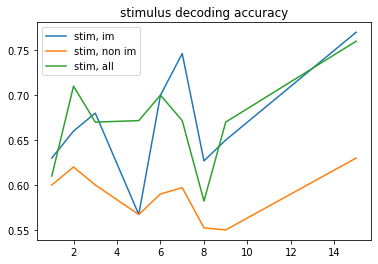

In [935]:
plt.plot(valid_days, accs[:, 2], label='stim, im')
plt.plot(valid_days, accs[:, 3], label='stim, non im')
plt.plot(valid_days, accs[:, 0], label='stim, all')
plt.legend()
plt.title('stimulus decoding accuracy')
plt.show()

Text(0.5, 1.0, 'jl009')

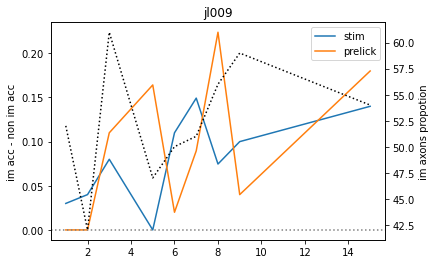

In [936]:
fig, ax1 = plt.subplots()
ax1.plot(valid_days, accs[:, 2] - accs[:, 3], label='stim')
ax1.plot(valid_days, accs[:, 4] - accs[:, 5], label='prelick')
ax1.set_ylabel('im acc - non im acc')
ax1.legend()
ax1.axhline(0, linestyle=':', color='gray')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(valid_days, n_im_axons, label='im axons propotion', color='black', linestyle=':')
ax2.set_ylabel('im axons propotion')
plt.title(mouse_name)

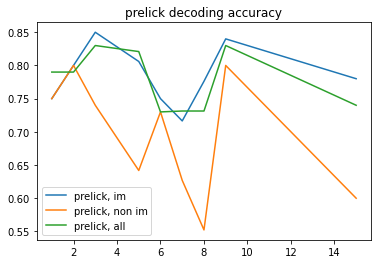

In [937]:
plt.plot(valid_days, accs[:, 4], label='prelick, im')
plt.plot(valid_days, accs[:, 5], label='prelick, non im')
plt.plot(valid_days, accs[:, 1], label='prelick, all')
plt.legend()
plt.title('prelick decoding accuracy')
plt.show()

### average weight

In [907]:
W_stim = np.zeros((len(valid_days), 90))
W_prelick = np.zeros((len(valid_days), 90))
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape
    print(daily_responses.shape)

    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)

    accs = []

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('accuracy predicting stimulus identity on test set: ', acc)
    accs.append(acc)
    print(model.coef_.shape)
    stim_weights = model.coef_.reshape((NA, NF))
    print(stim_weights.shape)
    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    # if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
    #     acc = 0.5
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], prelick[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    prelick_weights = model.coef_.reshape((NA, NF))
    print('accuracy predicting prelick on test set: ', acc)
    accs.append(acc)

    idx, non_idx = important_axons(stim_weights)
    NNA = len(idx)
    spks = spks.reshape(NT, NA, NF)

    axon_spks = spks[:, idx, :]
    axon_spks = axon_spks.reshape(NT, -1)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(axon_spks[itrain], stim[itrain])
    te_pred = model.predict(axon_spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    stim_weights = model.coef_.reshape((NNA, NF))
    W_stim[i] = np.mean(np.abs(stim_weights), axis=0)
    
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(axon_spks[itrain], prelick[itrain])
    te_pred = model.predict(axon_spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    prelick_weights = model.coef_.reshape((NNA, NF))
    W_prelick[i] = np.mean(np.abs(prelick_weights), axis=0)
    print('[important]accuracy predicting prelick on test set: ', acc)

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 447, 90)
(300, 40230)
accuracy predicting stimulus identity on test set:  0.49
(1, 40230)
(447, 90)
accuracy predicting prelick on test set:  0.82
[important]accuracy predicting prelick on test set:  0.77
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 386, 90)
(300, 34740)
accuracy predicting stimulus identity on test set:  0.67
(1, 34740)
(386, 90)
accuracy predicting prelick on test set:  0.79
[important]accuracy predicting prelick on test set:  0.76
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
(200, 313, 90)
(200, 28170)
accuracy predicting stimulus identity on test set:  0.5522388059701493
(1, 28170)
(313, 90)
accuracy predicting prelick on test set:  0.7761194029850746
[important]accuracy predicting prelick on test set:  0.7611940298507462
-------------------day 5----------------

Text(0.5, 1.0, 'stimulus weights of important axons, fz017')

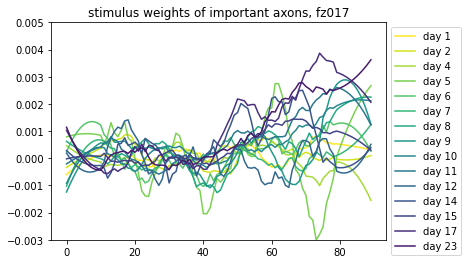

In [911]:
from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')
for i, day in enumerate(valid_days[:15]):
    y = W_stim[i] - np.mean(W_stim[i, :45])
    yhat = savgol_filter(y, 21, 2)
    plt.plot(np.arange(NF), yhat, label='day {}'.format(day), color=cmap(i/len(valid_days[:15])))
plt.ylim([-0.003, 0.005])
plt.legend(bbox_to_anchor=(1, 1))
plt.title('stimulus weights of important axons, {}'.format(mouse_name))

In [676]:
print(valid_days)

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 23, 24, 25, 26]


Text(0.5, 1.0, 'prelick weights of important axons, fz017')

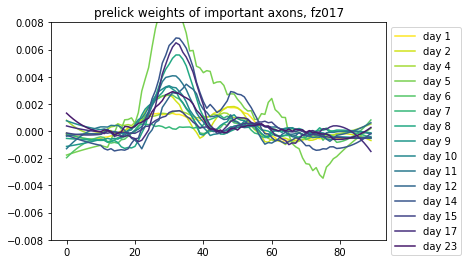

In [910]:
from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')
for i, day in enumerate(valid_days[:15]):
    y = W_prelick[i] - np.mean(W_prelick[i, 45:])
    yhat = savgol_filter(y, 21, 2)
    plt.plot(np.arange(NF), yhat, label='day {}'.format(day), color=cmap(i/len(valid_days[:15])))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim([-0.008, 0.008])
plt.title('prelick weights of important axons, {}'.format(mouse_name))

#### original classifier

In [941]:
W_stim_im = np.zeros((len(valid_days), 90))
W_prelick_im = np.zeros((len(valid_days), 90))
W_stim_nonim = np.zeros((len(valid_days), 90))
W_prelick_nonim = np.zeros((len(valid_days), 90))
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape
    print(daily_responses.shape)

    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)

    accs = []

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('accuracy predicting stimulus identity on test set: ', acc)
    accs.append(acc)
    print(model.coef_.shape)
    stim_weights = model.coef_.reshape((NA, NF))
    print(stim_weights.shape)
    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    # if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
    #     acc = 0.5
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], prelick[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    prelick_weights = model.coef_.reshape((NA, NF))
    print('accuracy predicting prelick on test set: ', acc)
    accs.append(acc)

    idx, non_idx = important_axons(stim_weights)
    spks = spks.reshape(NT, NA, NF)
    
    W_stim_im[i] = np.mean(np.abs(stim_weights[idx]), axis=0)
    W_prelick_im[i] = np.mean(np.abs(prelick_weights[idx]), axis=0)
    W_stim_nonim[i] = np.mean(np.abs(stim_weights[non_idx]), axis=0)
    W_prelick_nonim[i] = np.mean(np.abs(prelick_weights[non_idx]), axis=0)

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 175, 90)
(300, 15750)
accuracy predicting stimulus identity on test set:  0.61
(1, 15750)
(175, 90)
accuracy predicting prelick on test set:  0.79
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 141, 90)
(300, 12690)
accuracy predicting stimulus identity on test set:  0.71
(1, 12690)
(141, 90)
accuracy predicting prelick on test set:  0.79
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
(300, 205, 90)
(300, 18450)
accuracy predicting stimulus identity on test set:  0.67
(1, 18450)
(205, 90)
accuracy predicting prelick on test set:  0.83
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
(200, 158, 90)
(200, 14220)
accuracy predicting stimulus identity on test set:  0.6716417910447762
(1, 14220)
(158, 90)
accuracy predicting prelick on test set: 

Text(0.5, 1.0, 'stimulus weights of important axons, jl009')

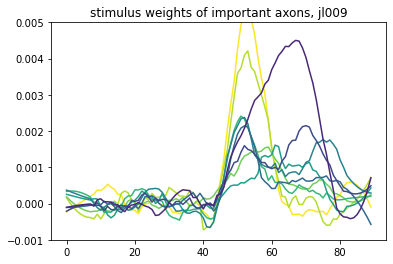

In [942]:
from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')
for i, day in enumerate(valid_days):
    y = W_stim_im[i] - np.mean(W_stim_im[i, :45])
    yhat = savgol_filter(y, 15, 2)
    plt.plot(np.arange(NF), yhat, label='day {}'.format(day), color=cmap(i/len(valid_days)))
plt.ylim([-0.001, 0.005])
# plt.legend(bbox_to_anchor=(1, 1))
plt.title('stimulus weights of important axons, {}'.format(mouse_name))

Text(0.5, 1.0, 'stimulus weights of non important axons, jl009')

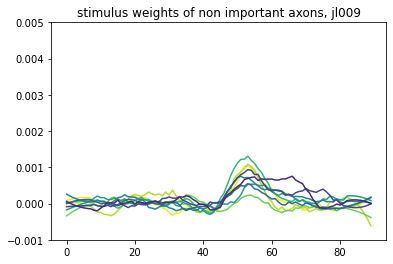

In [943]:
from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')
for i, day in enumerate(valid_days):
    y = W_stim_nonim[i] - np.mean(W_stim_nonim[i, :45])
    yhat = savgol_filter(y, 15, 2)
    plt.plot(np.arange(NF), yhat, label='day {}'.format(day), color=cmap(i/len(valid_days)))
plt.ylim([-0.001, 0.005])
# plt.legend(bbox_to_anchor=(1, 1))
plt.title('stimulus weights of non important axons, {}'.format(mouse_name))

Text(0.5, 1.0, 'prelick weights of important axons, jl009')

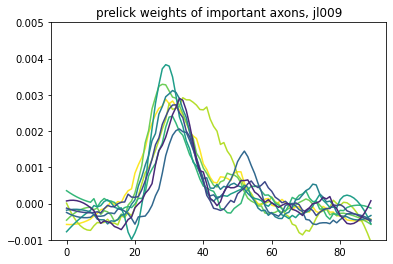

In [944]:
from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')
for i, day in enumerate(valid_days):
    y = W_prelick_im[i] - np.mean(W_prelick_im[i, 45:])
    yhat = savgol_filter(y, 15, 2)
    plt.plot(np.arange(NF), yhat, label='day {}'.format(day), color=cmap(i/len(valid_days)))
# plt.legend(bbox_to_anchor=(1, 1))
plt.ylim([-0.001, 0.005])
plt.title('prelick weights of important axons, {}'.format(mouse_name))

Text(0.5, 1.0, 'prelick weights of non important axons, jl009')

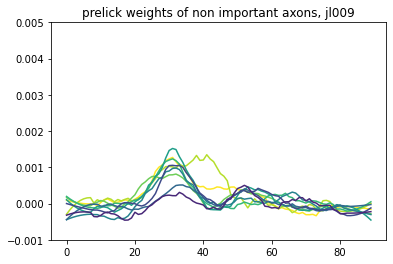

In [945]:
from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')
for i, day in enumerate(valid_days):
    y = W_prelick_nonim[i] - np.mean(W_prelick_nonim[i, 45:])
    yhat = savgol_filter(y, 15, 2)
    plt.plot(np.arange(NF), yhat, label='day {}'.format(day), color=cmap(i/len(valid_days)))
# plt.legend(bbox_to_anchor=(1, 1))
plt.ylim([-0.001, 0.005])
plt.title('prelick weights of non important axons, {}'.format(mouse_name))

### axon response under different outcome

(300, 447, 90)
(300, 40230)
accuracy predicting stimulus identity on test set:  0.49
(1, 40230)
(447, 90)
(47, 89, 90)
(103, 89, 90)
(54, 89, 90)
(96, 89, 90)


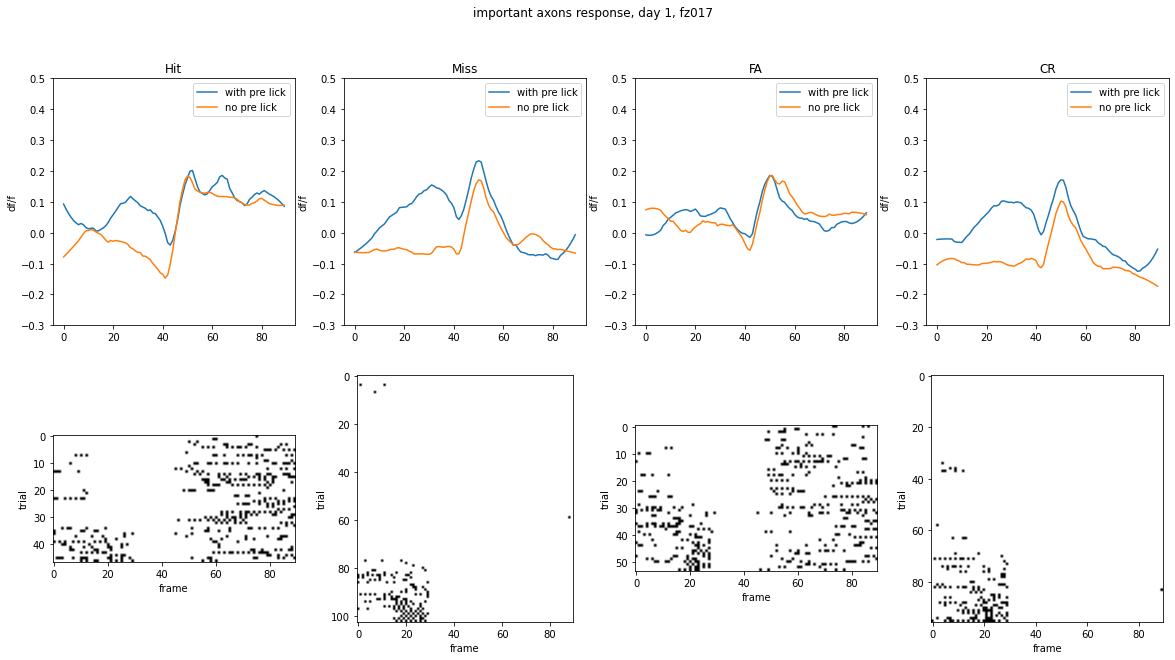

In [1003]:
day = 1
iblocks = daily_blocks(data, day)
plt.figure(figsize=(20, 10))
if len(iblocks)>0:
    daily_cues = []
    daily_outcomes = []
    daily_responses = []
    daily_firstlicks = []
    daily_alllicks = []
    for i in iblocks:
        block = data[0, i]
        # normalize doesn't have much effect on the result, so set it to False
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=True, dff=False, window=[45,45])
        daily_cues.append(cues)
        daily_outcomes.append(outcomes)
        daily_responses.append(stim_resp)
        daily_firstlicks.append(firstlicks)
        daily_alllicks.append(alllicks)

    daily_cues = np.hstack(daily_cues)
    daily_outcomes = np.hstack(daily_outcomes)
    daily_responses = np.vstack(daily_responses)
    daily_firstlicks = np.hstack(daily_firstlicks)
    daily_alllicks = np.vstack(daily_alllicks)

    NN = daily_responses.shape[1]
    
    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape
    print(daily_responses.shape)

    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)
    
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('accuracy predicting stimulus identity on test set: ', acc)
    accs.append(acc)
    print(model.coef_.shape)
    stim_weights = model.coef_.reshape((NA, NF))
    print(stim_weights.shape)

    idx, non_idx = important_axons(stim_weights)
    spks = spks.reshape(NT, NA, NF)
    NNA = len(idx)

    axon_spks = spks[:, idx, :] 
    # axon_spks = axon_spks.reshape(NT, -1)
    # non_axon_spks = spks[:, non_idx, :]
    # non_axon_spks = non_axon_spks.reshape(NT, -1)

    for outcome_index in range(1,5):
        # hit responses
        ioutcome = np.where(daily_outcomes == outcome_index)[0]
        resp = axon_spks[ioutcome]
        print(resp.shape)

        lick = daily_alllicks[ioutcome]
        n_prelicks = np.sum(lick[:, 15:30], axis=1)
        lick_idx = np.where(n_prelicks != 0)[0]
        resp_lick = resp[lick_idx].reshape(-1, NF)
        resp_lick = np.mean(resp_lick, axis=0)
        nolick_idx = np.where(n_prelicks == 0)[0]
        resp_nolick = resp[nolick_idx].reshape(-1, NF)
        resp_nolick = np.mean(resp_nolick, axis=0)
        lick_sort = np.argsort(n_prelicks)
        lick = lick[lick_sort]

        resp = resp.reshape(-1, NF)
        all_resp = np.mean(resp, axis=0)

        plt.subplot(2,4,outcome_index)
        x = np.arange(NF)
        resp_lick = savgol_filter(resp_lick, 13, 2)
        resp_nolick = savgol_filter(resp_nolick, 13, 2)
        plt.plot(x, resp_lick, label='with pre lick')
        plt.plot(x, resp_nolick, label='no pre lick')
        
        plt.ylim([-0.3, 0.5])
        # plt.plot(x, all_resp, label='all', color='black', linestyle='--')
        plt.title(outcome_list[outcome_index-1])
        plt.legend()
        plt.ylabel('df/f')
        plt.subplot(2,4,4+outcome_index)
        plt.imshow(lick, cmap='binary')
        plt.xlabel('frame')
        plt.ylabel('trial')
    plt.suptitle('important axons response, day {}, {}'.format(day, mouse_name))
    plt.show()
    

#### all seperate figure

In [1025]:
pre_window = 45
for day in valid_days:
    iblocks = daily_blocks(data, day)
    plt.figure(figsize=(20, 10))
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for i in iblocks:
            block = data[0, i]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=True, dff=False, window=[pre_window, 45])
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_firstlicks = np.hstack(daily_firstlicks)
        daily_alllicks = np.vstack(daily_alllicks)

        NN = daily_responses.shape[1]

        nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
        inotnan = np.where(nanflag==0)
        daily_responses = daily_responses[inotnan]
        daily_cues = daily_cues[inotnan]
        daily_outcomes = daily_outcomes[inotnan]
        daily_alllicks = daily_alllicks[inotnan]
        NT, NA, NF = daily_responses.shape
        print(daily_responses.shape)

        stim = np.ones(daily_cues.shape)
        stim[np.where(daily_cues==2)] = 0 
        stim[np.where(daily_cues==4)] = 0
        stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

        spks = daily_responses.reshape(daily_responses.shape[0], -1)
        print(spks.shape)

        random.seed(0)
        np.random.seed(0)
        itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
        itest = np.setxor1d(np.arange(NT), itrain)

        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(spks[itrain], stim[itrain])
        te_pred = model.predict(spks[itest])
        acc = np.sum(te_pred == stim[itest]) / len(itest)
        print('accuracy predicting stimulus identity on test set: ', acc)
        accs.append(acc)
        print(model.coef_.shape)
        stim_weights = model.coef_.reshape((NA, NF))
        print(stim_weights.shape)

        thresh = 0.001
        axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
        axons_contribution_prelick = np.mean(prelick_weights[:, :45], axis=1)
        idx = np.where(axons_contribution > thresh)[0]
        non_idx = np.where(axons_contribution <= thresh)[0]
        spks = spks.reshape(NT, NA, NF)
        NNA = len(idx)

        axon_spks = spks[:, idx, :] 
        # axon_spks = axon_spks.reshape(NT, -1)
        # non_axon_spks = spks[:, non_idx, :]
        # non_axon_spks = non_axon_spks.reshape(NT, -1)

        for outcome_index in range(1,5):
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = axon_spks[ioutcome]
            print(resp.shape)

            lick = daily_alllicks[ioutcome]
            n_prelicks = np.sum(lick[:, 15:30], axis=1)
            lick_idx = np.where(n_prelicks != 0)[0]
            resp_lick = resp[lick_idx].reshape(-1, NF)
            resp_lick = np.mean(resp_lick, axis=0)
            nolick_idx = np.where(n_prelicks == 0)[0]
            resp_nolick = resp[nolick_idx].reshape(-1, NF)
            resp_nolick = np.mean(resp_nolick, axis=0)
            lick_sort = np.argsort(n_prelicks)
            lick = lick[lick_sort]

            resp = resp.reshape(-1, NF)
            all_resp = np.mean(resp, axis=0)

            plt.subplot(2,4,outcome_index)
            x = np.arange(NF)
            resp_lick = savgol_filter(resp_lick, 13, 2)
            resp_nolick = savgol_filter(resp_nolick, 13, 2)
            plt.plot(x, resp_lick, label='with pre lick')
            plt.plot(x, resp_nolick, label='no pre lick')
            plt.ylim([-0.3, 0.5])
            # plt.plot(x, all_resp, label='all', color='black', linestyle='--')
            plt.title(outcome_list[outcome_index-1])
            plt.legend()
            plt.ylabel('df/f')
            plt.subplot(2,4,4+outcome_index)
            plt.imshow(lick, cmap='binary')
            plt.xlabel('frame')
            plt.ylabel('trial')
        plt.suptitle('important axons response, day {}, {}'.format(day, mouse_name))
        fig_save_path = os.path.join('figures',  'imaxons-zscore-avg_stim-evoke-response-prelickornot_{}_day-{}'.format(mouse_name, day))
        plt.savefig(fig_save_path, dpi=100)
        plt.close()

(300, 175, 90)
(300, 15750)
accuracy predicting stimulus identity on test set:  0.61
(1, 15750)
(175, 90)
(72, 82, 90)
(78, 82, 90)
(69, 82, 90)
(81, 82, 90)
(300, 141, 90)
(300, 12690)
accuracy predicting stimulus identity on test set:  0.71
(1, 12690)
(141, 90)
(90, 78, 90)
(60, 78, 90)
(82, 78, 90)
(68, 78, 90)
(300, 205, 90)
(300, 18450)
accuracy predicting stimulus identity on test set:  0.67
(1, 18450)
(205, 90)
(104, 102, 90)
(46, 102, 90)
(69, 102, 90)
(81, 102, 90)
(200, 158, 90)
(200, 14220)
accuracy predicting stimulus identity on test set:  0.6716417910447762
(1, 14220)
(158, 90)
(98, 89, 90)
(2, 89, 90)
(77, 89, 90)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(23, 89, 90)
(300, 169, 90)
(300, 15210)
accuracy predicting stimulus identity on test set:  0.7
(1, 15210)
(169, 90)
(130, 52, 90)
(20, 52, 90)
(102, 52, 90)
(48, 52, 90)
(200, 171, 90)
(200, 15390)
accuracy predicting stimulus identity on test set:  0.6716417910447762
(1, 15390)
(171, 90)
(72, 97, 90)
(28, 97, 90)
(50, 97, 90)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(50, 97, 90)
(200, 187, 90)
(200, 16830)
accuracy predicting stimulus identity on test set:  0.582089552238806
(1, 16830)
(187, 90)
(63, 77, 90)
(37, 77, 90)
(47, 77, 90)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(53, 77, 90)
(300, 198, 90)
(300, 17820)
accuracy predicting stimulus identity on test set:  0.67
(1, 17820)
(198, 90)
(127, 110, 90)
(23, 110, 90)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(89, 110, 90)
(61, 110, 90)
(300, 180, 90)
(300, 16200)
accuracy predicting stimulus identity on test set:  0.76
(1, 16200)
(180, 90)
(113, 114, 90)
(37, 114, 90)
(56, 114, 90)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(94, 114, 90)


#### all in one figure across days

In [1056]:
resp_lick_all_im = np.zeros((len(valid_days), 4,  NF))
resp_nolick_all_im = np.zeros((len(valid_days),4,  NF))
resp_lick_all_nonim = np.zeros((len(valid_days), 4,  NF))
resp_nolick_all_nonim = np.zeros((len(valid_days),4,  NF))
resp_all_im = np.zeros((len(valid_days),4,  NF))
resp_all_nonim = np.zeros((len(valid_days),4,  NF))
for iday, day in enumerate(valid_days):
    resp_lick_sum_im = np.zeros((4, NF))
    resp_nolick_sum_im = np.zeros((4, NF))
    resp_lick_sum_nonim = np.zeros((4, NF))
    resp_nolick_sum_nonim = np.zeros((4, NF))
    resp_all_sum_im = np.zeros((4, NF))
    resp_all_sum_nonim = np.zeros((4, NF))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for i in iblocks:
            block = data[0, i]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=True, dff=False, window=[pre_window, 45])
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_firstlicks = np.hstack(daily_firstlicks)
        daily_alllicks = np.vstack(daily_alllicks)

        NN = daily_responses.shape[1]

        nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
        inotnan = np.where(nanflag==0)
        daily_responses = daily_responses[inotnan]
        daily_cues = daily_cues[inotnan]
        daily_outcomes = daily_outcomes[inotnan]
        daily_alllicks = daily_alllicks[inotnan]
        NT, NA, NF = daily_responses.shape
        print(daily_responses.shape)

        stim = np.ones(daily_cues.shape)
        stim[np.where(daily_cues==2)] = 0 
        stim[np.where(daily_cues==4)] = 0
        stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

        spks = daily_responses.reshape(daily_responses.shape[0], -1)
        print(spks.shape)

        random.seed(0)
        np.random.seed(0)
        itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
        itest = np.setxor1d(np.arange(NT), itrain)

        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(spks[itrain], stim[itrain])
        te_pred = model.predict(spks[itest])
        acc = np.sum(te_pred == stim[itest]) / len(itest)
        print('accuracy predicting stimulus identity on test set: ', acc)
        accs.append(acc)
        print(model.coef_.shape)
        stim_weights = model.coef_.reshape((NA, NF))
        print(stim_weights.shape)

        idx, non_idx = important_axons(stim_weights, proportion=im_proportion)
        spks = spks.reshape(NT, NA, NF)
        NNA = len(idx)

        axon_spks = spks[:, idx, :] 
        # axon_spks = axon_spks.reshape(NT, -1)
        # non_axon_spks = spks[:, non_idx, :]
        # non_axon_spks = non_axon_spks.reshape(NT, -1)

        for outcome_index in range(1,5):
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = axon_spks[ioutcome]
            print(resp.shape)

            lick = daily_alllicks[ioutcome]
            n_prelicks = np.sum(lick[:, 15:30], axis=1)
            lick_idx = np.where(n_prelicks != 0)[0]
            resp_lick = resp[lick_idx].reshape(-1, NF)
            resp_lick = np.mean(resp_lick, axis=0)
            nolick_idx = np.where(n_prelicks == 0)[0]
            resp_nolick = resp[nolick_idx].reshape(-1, NF)
            resp_nolick = np.mean(resp_nolick, axis=0)
            lick_sort = np.argsort(n_prelicks)
            lick = lick[lick_sort]

            resp = resp.reshape(-1, NF)
            all_resp = np.mean(resp, axis=0)

            x = np.arange(NF)
            # resp_lick = savgol_filter(resp_lick, 13, 2)
            # resp_nolick = savgol_filter(resp_nolick, 13, 2)
            resp_lick_sum_im[outcome_index-1] = resp_lick
            resp_nolick_sum_im[outcome_index-1] = resp_nolick
            resp_all_sum_im[outcome_index-1] = all_resp
            
        NNA = len(non_idx)
        axon_spks = spks[:, non_idx, :] 

        for outcome_index in range(1,5):
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = axon_spks[ioutcome]
            print(resp.shape)

            lick = daily_alllicks[ioutcome]
            n_prelicks = np.sum(lick[:, 15:30], axis=1)
            lick_idx = np.where(n_prelicks != 0)[0]
            resp_lick = resp[lick_idx].reshape(-1, NF)
            resp_lick = np.mean(resp_lick, axis=0)
            nolick_idx = np.where(n_prelicks == 0)[0]
            resp_nolick = resp[nolick_idx].reshape(-1, NF)
            resp_nolick = np.mean(resp_nolick, axis=0)
            lick_sort = np.argsort(n_prelicks)
            lick = lick[lick_sort]

            resp = resp.reshape(-1, NF)
            all_resp = np.mean(resp, axis=0)

            x = np.arange(NF)
            # resp_lick = savgol_filter(resp_lick, 13, 2)
            # resp_nolick = savgol_filter(resp_nolick, 13, 2)
            resp_lick_sum_nonim[outcome_index-1] = resp_lick
            resp_nolick_sum_nonim[outcome_index-1] = resp_nolick
            resp_all_sum_nonim[outcome_index-1] = all_resp
            

    resp_lick_all_im[iday] = resp_lick_sum_im
    resp_nolick_all_im[iday] = resp_nolick_sum_im
    resp_lick_all_nonim[iday] = resp_lick_sum_nonim
    resp_nolick_all_nonim[iday] = resp_nolick_sum_nonim
    resp_all_im[iday] = resp_all_sum_im
    resp_all_nonim[iday] = resp_all_sum_nonim
    

(300, 175, 90)
(300, 15750)
accuracy predicting stimulus identity on test set:  0.61
(1, 15750)
(175, 90)
(72, 52, 90)
(78, 52, 90)
(69, 52, 90)
(81, 52, 90)
(72, 123, 90)
(78, 123, 90)
(69, 123, 90)
(81, 123, 90)
(300, 141, 90)
(300, 12690)
accuracy predicting stimulus identity on test set:  0.71
(1, 12690)
(141, 90)
(90, 42, 90)
(60, 42, 90)
(82, 42, 90)
(68, 42, 90)
(90, 99, 90)
(60, 99, 90)
(82, 99, 90)
(68, 99, 90)
(300, 205, 90)
(300, 18450)
accuracy predicting stimulus identity on test set:  0.67
(1, 18450)
(205, 90)
(104, 61, 90)
(46, 61, 90)
(69, 61, 90)
(81, 61, 90)
(104, 144, 90)
(46, 144, 90)
(69, 144, 90)
(81, 144, 90)
(200, 158, 90)
(200, 14220)
accuracy predicting stimulus identity on test set:  0.6716417910447762
(1, 14220)
(158, 90)
(98, 47, 90)
(2, 47, 90)
(77, 47, 90)
(23, 47, 90)
(98, 111, 90)
(2, 111, 90)
(77, 111, 90)
(23, 111, 90)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(300, 169, 90)
(300, 15210)
accuracy predicting stimulus identity on test set:  0.7
(1, 15210)
(169, 90)
(130, 50, 90)
(20, 50, 90)
(102, 50, 90)
(48, 50, 90)
(130, 119, 90)
(20, 119, 90)
(102, 119, 90)
(48, 119, 90)
(200, 171, 90)
(200, 15390)
accuracy predicting stimulus identity on test set:  0.6716417910447762
(1, 15390)
(171, 90)
(72, 51, 90)
(28, 51, 90)
(50, 51, 90)
(50, 51, 90)
(72, 120, 90)
(28, 120, 90)
(50, 120, 90)
(50, 120, 90)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(200, 187, 90)
(200, 16830)
accuracy predicting stimulus identity on test set:  0.582089552238806
(1, 16830)
(187, 90)
(63, 56, 90)
(37, 56, 90)
(47, 56, 90)
(53, 56, 90)
(63, 131, 90)
(37, 131, 90)
(47, 131, 90)
(53, 131, 90)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(300, 198, 90)
(300, 17820)
accuracy predicting stimulus identity on test set:  0.67
(1, 17820)
(198, 90)
(127, 59, 90)
(23, 59, 90)
(89, 59, 90)
(61, 59, 90)
(127, 139, 90)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(23, 139, 90)
(89, 139, 90)
(61, 139, 90)
(300, 180, 90)
(300, 16200)
accuracy predicting stimulus identity on test set:  0.76
(1, 16200)
(180, 90)
(113, 54, 90)
(37, 54, 90)
(56, 54, 90)
(94, 54, 90)
(113, 126, 90)
(37, 126, 90)
(56, 126, 90)
(94, 126, 90)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


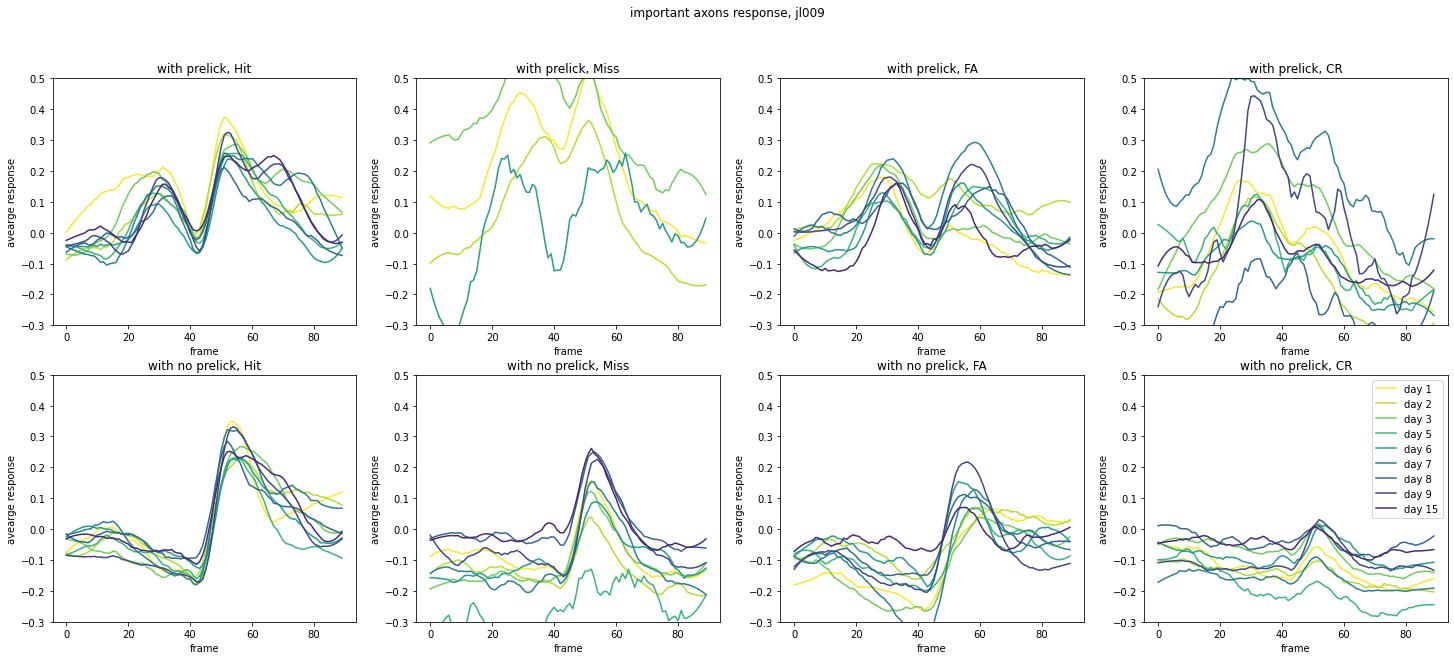

In [1035]:
im = True
if im:
    resp_lick_all = resp_lick_all_im
    resp_nolick_all = resp_nolick_all_im
else:
    resp_lick_all = resp_lick_all_nonim
    resp_nolick_all = resp_nolick_all_nonim
cmap = plt.cm.get_cmap('viridis_r')
plt.figure(figsize=(25, 10))
for outcome_index in range(4):
    plt.subplot(2,4,outcome_index+1)
    for iday, days in enumerate(valid_days):
        y = resp_lick_all[iday, outcome_index]
        # min_resp = np.max(y[35:45])
        # y = y - min_resp
        y = savgol_filter(y, 13, 2)
        plt.plot(np.arange(NF), y, label='dat {}'.format(day), color=cmap(iday/len(valid_days)))
    # plt.legend()
    plt.title('with prelick, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.3, 0.5])
    
    plt.subplot(2,4,5+outcome_index)
    for iday, day in enumerate(valid_days):
        y = resp_nolick_all[iday, outcome_index]
        # min_resp = np.min(y[35:45])
        # y = y - min_resp
        y = savgol_filter(y, 13, 2)
        plt.plot(np.arange(NF), y, label='day {}'.format(day), color=cmap(iday/len(valid_days)))
    # plt.legend()
    plt.title('with no prelick, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.3, 0.5])
plt.legend(bbox_to_anchor=(1, 1))
if im:
    plt.suptitle('important axons response, {}'.format(mouse_name))
else:
    plt.suptitle('non important axons response, {}'.format(mouse_name))

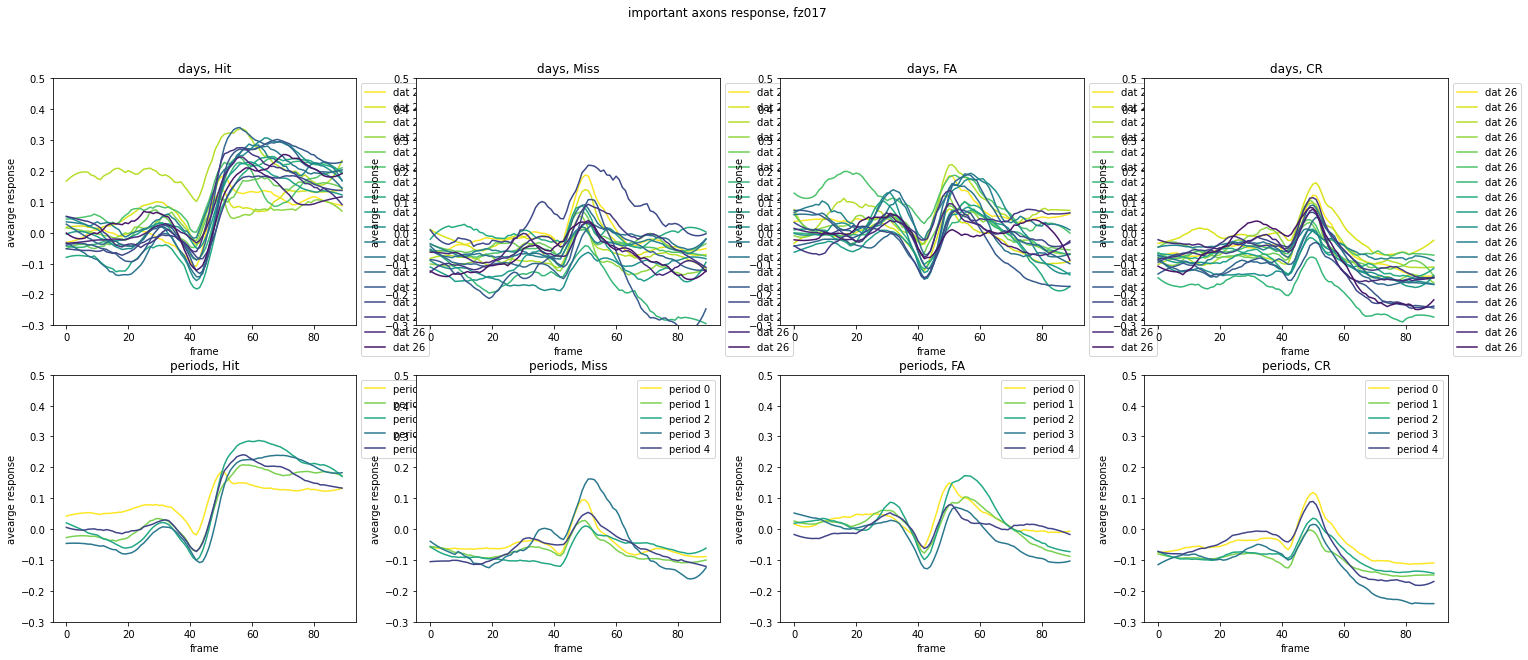

In [1054]:
im = True
if im:
    resp_all = resp_all_im
else:
    resp_all = resp_all_nonim
    
day_groups = day_groups_all[mouse_id]
resp_all_period = np.zeros((len(day_groups), 4,  NF))
for outcome_index in range(4):
    for igroup, days in enumerate(day_groups):
        rsum = np.zeros(NF)
        for d in days:
            iday = np.where(d==np.array(valid_days))
            y = resp_all[iday, outcome_index]
            rsum += np.squeeze(y)
        rsum = rsum/len(days)
        resp_all_period[igroup, outcome_index] = rsum
# sum of with and without prelick, focus on the response after the stimulus.
cmap = plt.cm.get_cmap('viridis_r')
plt.figure(figsize=(25, 10))
for outcome_index in range(4):
    plt.subplot(2,4,outcome_index+1)
    for iday, days in enumerate(valid_days):
        y = resp_all[iday, outcome_index] 
        # min_resp = np.max(y[35:45])
        # y = y - min_resp
        y = savgol_filter(y, 13, 2)
        plt.plot(np.arange(NF), y, label='dat {}'.format(day), color=cmap(iday/len(valid_days)))
    # plt.legend()
    plt.title('days, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.3, 0.5])
    plt.legend(bbox_to_anchor=(1, 1))
    
    plt.subplot(2,4,outcome_index+5)
    for igroup, days in enumerate(day_groups):
        y = resp_all_period[igroup, outcome_index]
        y = savgol_filter(y, 13, 2)
        # min_resp = np.max(y[35:45])
        # y = y - min_resp
        plt.plot(np.arange(NF), y, label='period {}'.format(igroup), color=cmap(igroup/len(day_groups)))
    plt.legend()
    plt.title('periods, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.3, 0.5])
    plt.legend(bbox_to_anchor=(1, 1))
    
if im:
    plt.suptitle('important axons response, {}'.format(mouse_name))
else:
    plt.suptitle('non important axons response, {}'.format(mouse_name))

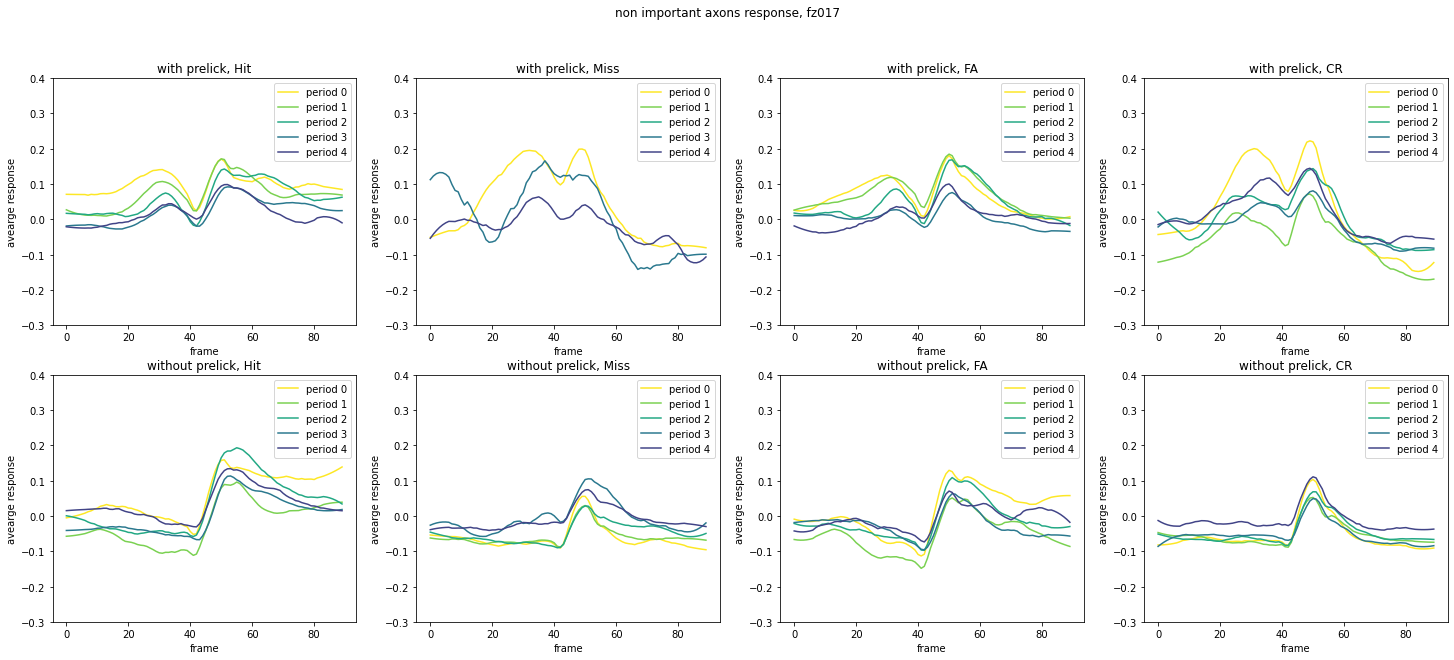

In [1053]:
im = False
if im:
    resp_lick_all = resp_lick_all_im
    resp_nolick_all = resp_nolick_all_im
else:
    resp_lick_all = resp_lick_all_nonim
    resp_nolick_all = resp_nolick_all_nonim
day_groups = day_groups_all[mouse_id]
resp_all_lick = np.zeros((len(day_groups), 4,  NF))
resp_all_nolick = np.zeros((len(day_groups), 4,  NF))
for outcome_index in range(4):
    for igroup, days in enumerate(day_groups):
        rsum_lick = np.zeros(NF)
        rsum_nolick = np.zeros(NF)
        for d in days:
            iday = np.where(d==np.array(valid_days))
            y = resp_lick_all[iday, outcome_index]
            rsum_lick += np.squeeze(y)
            y = resp_nolick_all[iday, outcome_index]
            rsum_nolick += np.squeeze(y)
        rsum_lick = rsum_lick/len(days)
        resp_all_lick[igroup, outcome_index] = rsum_lick
        rsum_nolick = rsum_nolick/len(days)
        resp_all_nolick[igroup, outcome_index] = rsum_nolick

cmap = plt.cm.get_cmap('viridis_r')
plt.figure(figsize=(25, 10))
for outcome_index in range(4):
    plt.subplot(2,4,outcome_index+1)
    for igroup, days in enumerate(day_groups):
        y = resp_all_lick[igroup, outcome_index]
        y = savgol_filter(y, 13, 2)
        # min_resp = np.max(y[35:45])
        # y = y - min_resp
        plt.plot(np.arange(NF), y, label='period {}'.format(igroup), color=cmap(igroup/len(day_groups)))
    plt.legend()
    plt.title('with prelick, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.3, 0.4])
    
    plt.subplot(2,4,outcome_index+5)
    for igroup, days in enumerate(day_groups):
        y = resp_all_nolick[igroup, outcome_index]
        y = savgol_filter(y, 13, 2)
        # min_resp = np.max(y[35:45])
        # y = y - min_resp
        plt.plot(np.arange(NF), y, label='period {}'.format(igroup), color=cmap(igroup/len(day_groups)))
    plt.legend()
    plt.title('without prelick, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.3, 0.4])
    
if im:
    plt.suptitle('important axons response, {}'.format(mouse_name))
else:
    plt.suptitle('non important axons response, {}'.format(mouse_name))

#### period

(300, 447, 90)
(300, 40230)
accuracy predicting stimulus identity on test set:  0.49
(1, 40230)
(447, 90)
(47, 26, 90)
(103, 26, 90)
(54, 26, 90)
(96, 26, 90)
(300, 386, 90)
(300, 34740)
accuracy predicting stimulus identity on test set:  0.67
(1, 34740)
(386, 90)
(63, 37, 90)
(87, 37, 90)
(69, 37, 90)
(81, 37, 90)
(200, 313, 90)
(200, 28170)
accuracy predicting stimulus identity on test set:  0.5522388059701493
(1, 28170)
(313, 90)
(20, 4, 90)
(80, 4, 90)
(21, 4, 90)
(79, 4, 90)
(200, 121, 90)
(200, 10890)
accuracy predicting stimulus identity on test set:  0.6865671641791045
(1, 10890)
(121, 90)
(62, 26, 90)
(38, 26, 90)
(54, 26, 90)
(46, 26, 90)
(200, 212, 90)
(200, 19080)
accuracy predicting stimulus identity on test set:  0.6119402985074627
(1, 19080)
(212, 90)
(34, 40, 90)
(66, 40, 90)
(31, 40, 90)
(69, 40, 90)
(200, 321, 90)
(200, 28890)
accuracy predicting stimulus identity on test set:  0.5074626865671642
(1, 28890)
(321, 90)
(26, 9, 90)
(74, 9, 90)
(24, 9, 90)
(76, 9, 90)
(20

e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(300, 405, 90)
(300, 36450)
accuracy predicting stimulus identity on test set:  0.7
(1, 36450)
(405, 90)
(123, 95, 90)
(27, 95, 90)
(85, 95, 90)
(65, 95, 90)
(200, 348, 90)
(200, 31320)
accuracy predicting stimulus identity on test set:  0.7313432835820896
(1, 31320)
(348, 90)
(71, 60, 90)
(29, 60, 90)
(57, 60, 90)
(43, 60, 90)
(200, 176, 90)
(200, 15840)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


accuracy predicting stimulus identity on test set:  0.6119402985074627
(1, 15840)
(176, 90)
(25, 47, 90)
(75, 47, 90)
(16, 47, 90)
(84, 47, 90)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(300, 217, 90)
(300, 19530)
accuracy predicting stimulus identity on test set:  0.69
(1, 19530)
(217, 90)
(85, 90, 90)
(65, 90, 90)
(49, 90, 90)
(101, 90, 90)
(200, 374, 90)
(200, 33660)
accuracy predicting stimulus identity on test set:  0.6119402985074627
(1, 33660)
(374, 90)
(59, 71, 90)
(41, 71, 90)
(53, 71, 90)
(47, 71, 90)
(400, 298, 90)
(400, 26820)
accuracy predicting stimulus identity on test set:  0.8432835820895522
(1, 26820)
(298, 90)
(180, 137, 90)
(20, 137, 90)
(135, 137, 90)
(65, 137, 90)
(300, 324, 90)
(300, 29160)
accuracy predicting stimulus identity on test set:  0.79
(1, 29160)
(324, 90)
(141, 119, 90)
(9, 119, 90)
(74, 119, 90)
(76, 119, 90)
(200, 250, 90)
(200, 22500)
accuracy predicting stimulus identity on test set:  0.6417910447761194
(1, 22500)
(250, 90)
(34, 52, 90)
(66, 52, 90)
(36, 52, 90)
(64, 52, 90)
(300, 236, 90)
(300, 21240)
accuracy predicting stimulus identity on test set:  0.76
(1, 21240)
(236, 90)
(114, 57, 90)
(36, 57, 90)
(75, 57, 90)
(75, 57, 90

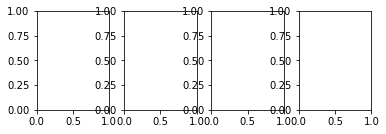

In [783]:
day_groups = day_groups_all[mouse_id]
resp_lick_all = np.zeros((len(day_groups), 4,  NF))
resp_nolick_all = np.zeros((len(day_groups),4,  NF))
for igroup, days in enumerate(day_groups):
    rsum = 0
    for d in days:
        resp_lick_sum = np.zeros((4, NF))
        resp_nolick_sum = np.zeros((4, NF))
        iblocks = daily_blocks(data, d)
        if len(iblocks)>0:
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            for i in iblocks:
                block = data[0, i]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=True, dff=False, window=[pre_window, 45])
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_responses.append(stim_resp)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_firstlicks = np.hstack(daily_firstlicks)
            daily_alllicks = np.vstack(daily_alllicks)

            NN = daily_responses.shape[1]

            nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
            inotnan = np.where(nanflag==0)
            daily_responses = daily_responses[inotnan]
            daily_cues = daily_cues[inotnan]
            daily_outcomes = daily_outcomes[inotnan]
            daily_alllicks = daily_alllicks[inotnan]
            NT, NA, NF = daily_responses.shape
            print(daily_responses.shape)

            stim = np.ones(daily_cues.shape)
            stim[np.where(daily_cues==2)] = 0 
            stim[np.where(daily_cues==4)] = 0
            stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

            spks = daily_responses.reshape(daily_responses.shape[0], -1)
            print(spks.shape)

            random.seed(0)
            np.random.seed(0)
            itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
            itest = np.setxor1d(np.arange(NT), itrain)

            model = LogisticRegression(solver='liblinear', random_state=0)
            model.fit(spks[itrain], stim[itrain])
            te_pred = model.predict(spks[itest])
            acc = np.sum(te_pred == stim[itest]) / len(itest)
            print('accuracy predicting stimulus identity on test set: ', acc)
            accs.append(acc)
            print(model.coef_.shape)
            stim_weights = model.coef_.reshape((NA, NF))
            print(stim_weights.shape)

            thresh = 0.001
            axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
            axons_contribution_prelick = np.mean(prelick_weights[:, :45], axis=1)
            idx = np.where(axons_contribution > thresh)[0]
            non_idx = np.where(axons_contribution <= thresh)[0]
            spks = spks.reshape(NT, NA, NF)
            NNA = len(idx)

            axon_spks = spks[:, idx, :] 
            # axon_spks = axon_spks.reshape(NT, -1)
            # non_axon_spks = spks[:, non_idx, :]
            # non_axon_spks = non_axon_spks.reshape(NT, -1)

            for outcome_index in range(1,5):
                # hit responses
                ioutcome = np.where(daily_outcomes == outcome_index)[0]
                resp = axon_spks[ioutcome]
                print(resp.shape)

                lick = daily_alllicks[ioutcome]
                n_prelicks = np.sum(lick[:, :15], axis=1)
                lick_idx = np.where(n_prelicks != 0)[0]
                resp_lick = resp[lick_idx].reshape(-1, NF)
                resp_lick = np.mean(resp_lick, axis=0)
                nolick_idx = np.where(n_prelicks == 0)[0]
                resp_nolick = resp[nolick_idx].reshape(-1, NF)
                resp_nolick = np.mean(resp_nolick, axis=0)
                lick_sort = np.argsort(n_prelicks)
                lick = lick[lick_sort]

                resp = resp.reshape(-1, NF)
                all_resp = np.mean(resp, axis=0)

                plt.subplot(2,4,outcome_index)
                x = np.arange(NF)
                resp_lick = savgol_filter(resp_lick, 13, 2)
                resp_nolick = savgol_filter(resp_nolick, 13, 2)
                resp_lick_sum[outcome_index-1] += resp_lick
                resp_nolick_sum[outcome_index-1] += resp_nolick
            
    resp_lick_sum = resp_lick_sum/len(days)
    resp_nolick_sum = resp_nolick_sum/len(days)
    resp_lick_all[igroup] = resp_lick_sum
    resp_nolick_all[igroup] = resp_nolick_sum

Text(0.5, 0.98, 'important axons response, fz017')

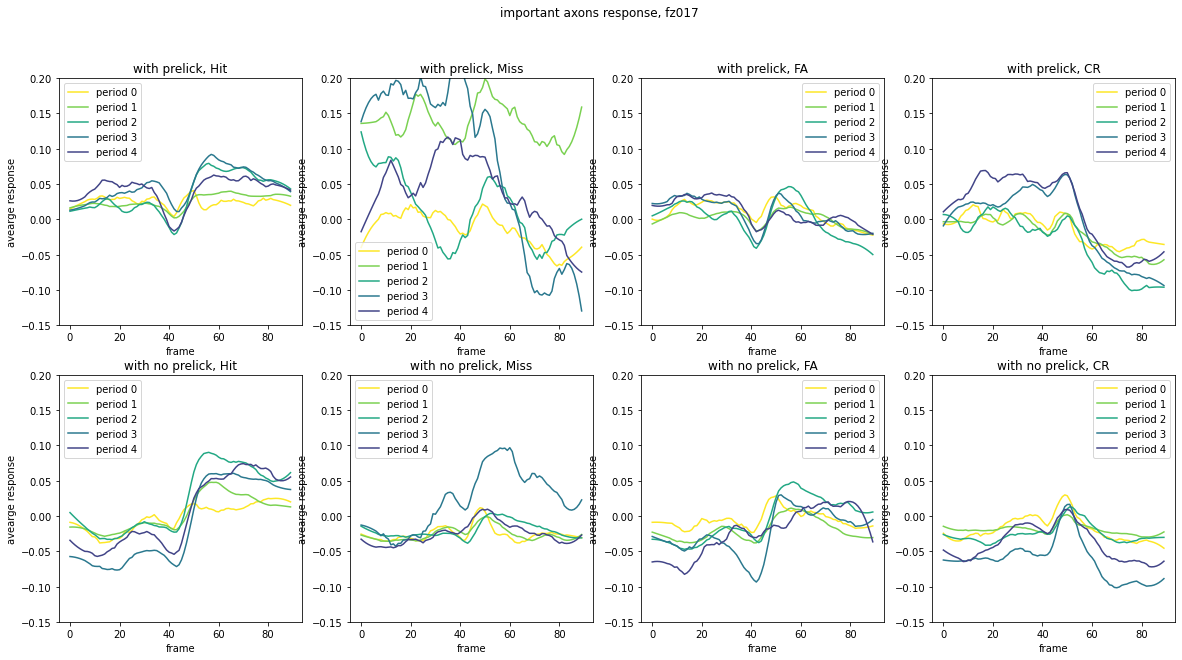

In [784]:
cmap = plt.cm.get_cmap('viridis_r')
plt.figure(figsize=(20, 10))
for outcome_index in range(4):
    plt.subplot(2,4,outcome_index+1)
    for igroup, days in enumerate(day_groups):
        y = resp_lick_all[igroup, outcome_index]
        # min_resp = np.max(y[35:45])
        # y = y - min_resp
        plt.plot(np.arange(NF), y, label='period {}'.format(igroup), color=cmap(igroup/len(day_groups)))
    plt.legend()
    plt.title('with prelick, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.15, 0.2])
    
    plt.subplot(2,4,5+outcome_index)
    for igroup, days in enumerate(day_groups):
        y = resp_nolick_all[igroup, outcome_index]
        # min_resp = np.min(y[35:45])
        # y = y - min_resp
        plt.plot(np.arange(NF), y, label='period {}'.format(igroup), color=cmap(igroup/len(day_groups)))
    plt.legend()
    plt.title('with no prelick, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.15, 0.2])
plt.suptitle('important axons response, {}'.format(mouse_name))

## stimuli prediction

### contribution of each time points (all)

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(100, 15030)
accuracy predicting stimulus identity on test set:  0.6176470588235294
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(100, 18900)
accuracy predicting stimulus identity on test set:  0.5
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
(200, 16830)
accuracy predicting stimulus identity on test set:  0.5970149253731343
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
(200, 9630)
accuracy predicting stimulus identity on test set:  0.5970149253731343
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
(200, 25290)
accuracy predicting stimulus identity on test set:  0.5671641791044776
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
(200, 19890)
accuracy pred

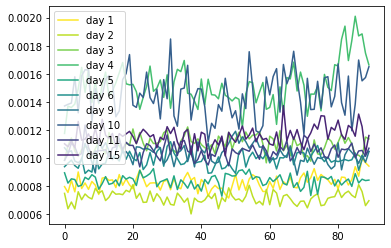

In [857]:
cmap = plt.cm.get_cmap('viridis_r')
pre_window=45
avg_w_all = []
NA_all = []
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)
    
    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    
    
    NT, NA, NF = daily_responses.shape
    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)

    model = LogisticRegression(solver='liblinear', random_state=0, C=0.001)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('accuracy predicting stimulus identity on test set: ', acc)

    weights = model.coef_.reshape((NA, NF))
    plt.plot(np.arange(NF), np.mean(np.abs(weights), axis=0), label='day {}'.format(day), color=cmap(i/len(valid_days)))
    avg_w_all.append(np.mean(np.abs(weights), axis=0))
    NA_all.append(NA)
plt.legend()

Text(0, 0.5, 'avearge weight')

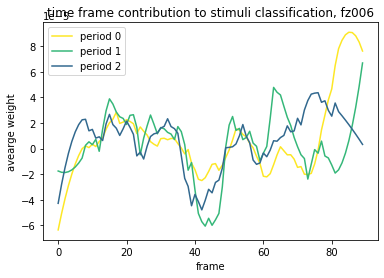

In [858]:
day_groups = day_groups_all[mouse_id]
for i, days in enumerate(day_groups):
    wsum = 0
    for d in days:
        idx = np.where(np.array(valid_days) == d)[0][0]
        wsum += avg_w_all[idx]
    wavg = wsum/len(days)
    wavg = wavg - np.mean(wavg[:45])
    wavg = savgol_filter(wavg, 15, 2)
    plt.plot(np.arange(NF), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
plt.legend()
plt.title('time frame contribution to stimuli classification, {}'.format(mouse_name))
plt.xlabel('frame')
plt.ylabel('avearge weight')

Text(0.5, 0, 'days')

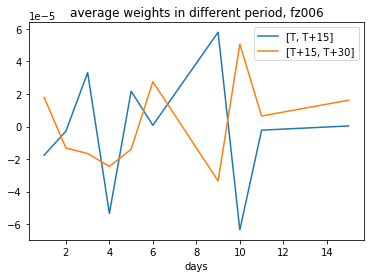

In [859]:
avg_w_all = np.array(avg_w_all)
base_w = np.mean(avg_w_all[:, :45], axis=1)
base_w = np.repeat(base_w[:, np.newaxis], avg_w_all.shape[1], axis=1)
avg_w_all_norm = avg_w_all - base_w
early_w = np.mean(avg_w_all_norm[:, 45:60], axis=1)
late_w = np.mean(avg_w_all_norm[:, 60:75], axis=1)
plt.plot(valid_days, early_w, label='[T, T+15]')
plt.plot(valid_days, late_w, label='[T+15, T+30]')
plt.title('average weights in different period, {}'.format(mouse_name))
plt.legend()
plt.xlabel('days')

Text(0.5, 1.0, 'inverse of axon number, fz006')

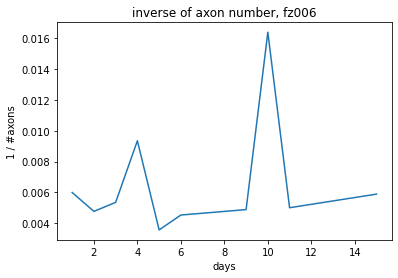

In [860]:
plt.plot(valid_days, 1/ np.array(NA_all))
plt.ylabel('1 / #axons')
plt.xlabel('days')
plt.title('inverse of axon number, {}'.format(mouse_name))

## prelick prediction

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 15750)
accuracy predicting prelick on test set:  0.79
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 12690)
accuracy predicting prelick on test set:  0.79
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
(300, 18450)
accuracy predicting prelick on test set:  0.83
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
(200, 14220)
accuracy predicting prelick on test set:  0.8208955223880597
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
(300, 15210)
accuracy predicting prelick on test set:  0.73
-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
(200, 15390)
accuracy predicting prelick on test set:  0.7313432835820896
-------------------day 8------------------

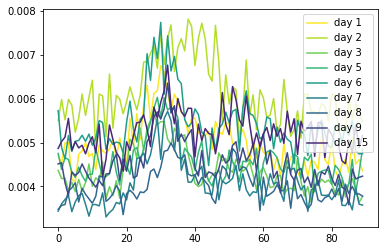

In [1097]:
cmap = plt.cm.get_cmap('viridis_r')
pre_window=45
avg_w_all = []
NA_all = []
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)
    
    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    
    
    NT, NA, NF = daily_responses.shape
    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)
    
    
    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    # if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
    #     acc = 0.5
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], prelick[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    weights = model.coef_.reshape((NA, NF))
    plt.plot(np.arange(NF), np.mean(np.abs(weights), axis=0), label='day {}'.format(day), color=cmap(i/len(valid_days)))
    avg_w_all.append(np.mean(np.abs(weights), axis=0))
    NA_all.append(NA)
    print('accuracy predicting prelick on test set: ', acc)
plt.legend()

Text(0, 0.5, 'avearge weight')

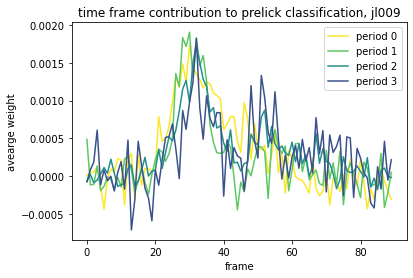

In [1101]:
day_groups = day_groups_all[mouse_id]
for i, days in enumerate(day_groups):
    wsum = 0
    for d in days:
        idx = np.where(np.array(valid_days) == d)[0][0]
        wsum += avg_w_all[idx]
    wavg = wsum/len(days)
    wavg = wavg - np.mean(wavg[:15])
    # wavg = savgol_filter(wavg, 7, 2)
    plt.plot(np.arange(NF), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
plt.legend()
plt.title('time frame contribution to prelick classification, {}'.format(mouse_name))
plt.xlabel('frame')
plt.ylabel('avearge weight')
# plt.ylim([-0.00025, 0.0025])

## postlick prediction

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 40230)
accuracy predicting postlick on test set:  0.8
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 34740)
accuracy predicting postlick on test set:  0.77
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
(200, 28170)
accuracy predicting postlick on test set:  0.835820895522388
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
(200, 10890)
accuracy predicting postlick on test set:  0.6567164179104478
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
(200, 19080)
accuracy predicting postlick on test set:  0.6119402985074627
-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
(200, 28890)
accuracy predicting postlick on test set:  0.8059701492537313
----------

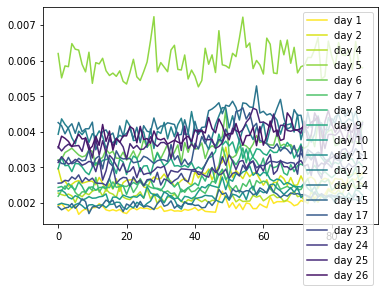

In [1091]:
cmap = plt.cm.get_cmap('viridis_r')
pre_window=45
avg_w_all = []
NA_all = []
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)
    
    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    
    
    NT, NA, NF = daily_responses.shape
    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)
    
    
    postlick = np.ones(daily_outcomes.shape)
    postlick[np.where(daily_outcomes==2)] = 0 
    postlick[np.where(daily_outcomes==4)] = 0
    postlick = np.multiply((postlick == 1), 1)  # lick: 1, nolick: 0
    # if (np.mean(postlick) == 0) or (np.mean(postlick) == 1):
    #     acc = 0.5
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], postlick[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == postlick[itest]) / len(itest)
    weights = model.coef_.reshape((NA, NF))
    plt.plot(np.arange(NF), np.mean(np.abs(weights), axis=0), label='day {}'.format(day), color=cmap(i/len(valid_days)))
    avg_w_all.append(np.mean(np.abs(weights), axis=0))
    NA_all.append(NA)
    print('accuracy predicting postlick on test set: ', acc)
plt.legend()

Text(0, 0.5, 'avearge weight')

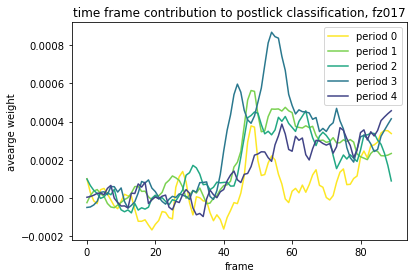

In [1092]:
day_groups = day_groups_all[mouse_id]
for i, days in enumerate(day_groups):
    wsum = 0
    for d in days:
        idx = np.where(np.array(valid_days) == d)[0][0]
        wsum += avg_w_all[idx]
    wavg = wsum/len(days)
    wavg = wavg - np.mean(wavg[:15])
    wavg = savgol_filter(wavg, 7, 2)
    plt.plot(np.arange(NF), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
plt.legend()
plt.title('time frame contribution to postlick classification, {}'.format(mouse_name))
plt.xlabel('frame')
plt.ylabel('avearge weight')
# plt.ylim([-0.00025, 0.0025])

### target tone

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 15750)
accuracy predicting postlick on test set:  0.72
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 12690)
accuracy predicting postlick on test set:  0.74
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
(300, 18450)
accuracy predicting postlick on test set:  0.86
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
(200, 12510)
accuracy predicting postlick on test set:  0.6470588235294118
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
(200, 14220)
accuracy predicting postlick on test set:  0.9705882352941176
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
(300, 15210)
accuracy predicting postlick on test set:  0.9
-------------------day 7-------------

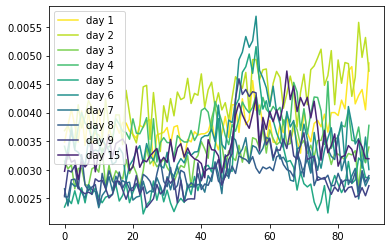

In [370]:
cmap = plt.cm.get_cmap('viridis_r')
pre_window=45
avg_w_all = []
NA_all = []
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)
    
    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    
    
    NT, NA, NF = daily_responses.shape
    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)
    tidx = np.where(stim == 1)[0]
    # fidx = np.where(stim == 0)[0]
    spks = spks[tidx]
    NT = len(tidx)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)
    
    
    postlick = np.ones(daily_outcomes.shape)
    postlick[np.where(daily_outcomes==2)] = 0 
    postlick[np.where(daily_outcomes==4)] = 0
    postlick = np.multiply((postlick == 1), 1)  # lick: 1, nolick: 0
    # if (np.mean(postlick) == 0) or (np.mean(postlick) == 1):
    #     acc = 0.5
    postlick = postlick[tidx]
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], postlick[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == postlick[itest]) / len(itest)
    weights = model.coef_.reshape((NA, NF))
    plt.plot(np.arange(NF), np.mean(np.abs(weights), axis=0), label='day {}'.format(day), color=cmap(i/len(valid_days)))
    avg_w_all.append(np.mean(np.abs(weights), axis=0))
    NA_all.append(NA)
    print('accuracy predicting postlick on test set: ', acc)
plt.legend()

Text(0, 0.5, 'avearge weight')

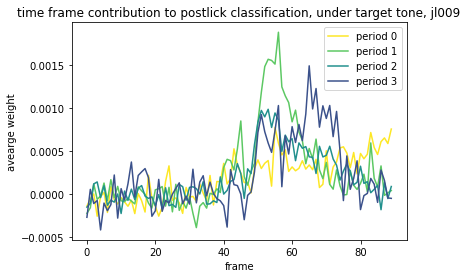

In [371]:
day_groups = day_groups_all[mouse_id]
if mouse_id == 1:
    day_groups =  [[1,2,4,5], [6,7,8,9,10], [11, 12,13,14,15], [17,23], [24,25,26]]
for i, days in enumerate(day_groups):
    wsum = 0
    for d in days:
        idx = np.where(np.array(valid_days) == d)[0][0]
        wsum += avg_w_all[idx]
    wavg = wsum/len(days)
    wavg = wavg - np.mean(wavg[:45])
    plt.plot(np.arange(NF), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
plt.legend()
plt.title('time frame contribution to postlick classification, under target tone, {}'.format(mouse_name))
plt.xlabel('frame')
plt.ylabel('avearge weight')

Text(0.5, 0, 'days')

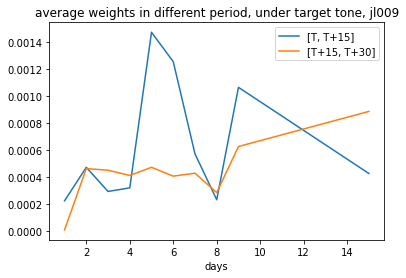

In [372]:
avg_w_all = np.array(avg_w_all)
base_w = np.mean(avg_w_all[:, :45], axis=1)
base_w = np.repeat(base_w[:, np.newaxis], avg_w_all.shape[1], axis=1)
avg_w_all_norm = avg_w_all - base_w
early_w = np.mean(avg_w_all_norm[:, 45:60], axis=1)
late_w = np.mean(avg_w_all_norm[:, 60:75], axis=1)
plt.plot(valid_days, early_w, label='[T, T+15]')
plt.plot(valid_days, late_w, label='[T+15, T+30]')
plt.title('average weights in different period, under target tone, {}'.format(mouse_name))
plt.legend()
plt.xlabel('days')

### foil tone

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 15750)
accuracy predicting postlick on test set:  0.72
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 12690)
accuracy predicting postlick on test set:  0.74
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
(300, 18450)
accuracy predicting postlick on test set:  0.66
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
(200, 12510)
accuracy predicting postlick on test set:  0.9117647058823529
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
(200, 14220)
accuracy predicting postlick on test set:  0.8529411764705882
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
(300, 15210)
accuracy predicting postlick on test set:  0.84
-------------------day 7------------

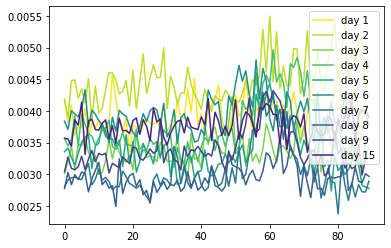

In [373]:
cmap = plt.cm.get_cmap('viridis_r')
pre_window=45
avg_w_all = []
NA_all = []
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)
    
    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    
    
    NT, NA, NF = daily_responses.shape
    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)
    # tidx = np.where(stim == 1)[0]
    fidx = np.where(stim == 0)[0]
    spks = spks[fidx]
    NT = len(fidx)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)
    
    
    postlick = np.ones(daily_outcomes.shape)
    postlick[np.where(daily_outcomes==2)] = 0 
    postlick[np.where(daily_outcomes==4)] = 0
    postlick = np.multiply((postlick == 1), 1)  # lick: 1, nolick: 0
    # if (np.mean(postlick) == 0) or (np.mean(postlick) == 1):
    #     acc = 0.5
    postlick = postlick[fidx]
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], postlick[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == postlick[itest]) / len(itest)
    weights = model.coef_.reshape((NA, NF))
    plt.plot(np.arange(NF), np.mean(np.abs(weights), axis=0), label='day {}'.format(day), color=cmap(i/len(valid_days)))
    avg_w_all.append(np.mean(np.abs(weights), axis=0))
    NA_all.append(NA)
    print('accuracy predicting postlick on test set: ', acc)
plt.legend()

Text(0, 0.5, 'avearge weight')

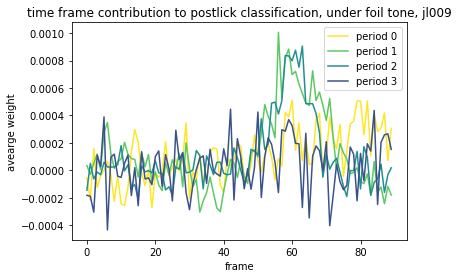

In [374]:
day_groups_all = [[[1,2,3], [4,5,6], [7,8,9], [15]], 
                 [[1,2,3,4,5], [6,7,8,9,10], [11, 12,13,14,15], [17,23], [24,25,26]],
                 [],
                 [[1,2,3,4,5], [6,9,10], [11,15]]]
day_groups = day_groups_all[mouse_id]
if mouse_id == 1:
    day_groups =  [[1,2,4,5], [6,7,8,9,10], [11, 12,13,14,15], [17,23], [24,25,26]]
for i, days in enumerate(day_groups):
    wsum = 0
    for d in days:
        idx = np.where(np.array(valid_days) == d)[0][0]
        wsum += avg_w_all[idx]
    wavg = wsum/len(days)
    wavg = wavg - np.mean(wavg[:45])
    plt.plot(np.arange(NF), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
plt.legend()
plt.title('time frame contribution to postlick classification, under foil tone, {}'.format(mouse_name))
plt.xlabel('frame')
plt.ylabel('avearge weight')

Text(0.5, 0, 'days')

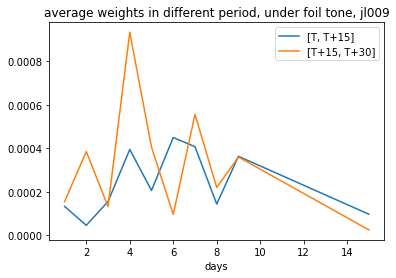

In [375]:
avg_w_all = np.array(avg_w_all)
base_w = np.mean(avg_w_all[:, :45], axis=1)
base_w = np.repeat(base_w[:, np.newaxis], avg_w_all.shape[1], axis=1)
avg_w_all_norm = avg_w_all - base_w
early_w = np.mean(avg_w_all_norm[:, 45:60], axis=1)
late_w = np.mean(avg_w_all_norm[:, 60:75], axis=1)
plt.plot(valid_days, early_w, label='[T, T+15]')
plt.plot(valid_days, late_w, label='[T+15, T+30]')
plt.title('average weights in different period, under foil tone, {}'.format(mouse_name))
plt.legend()
plt.xlabel('days')

# predict lick

In [400]:
cmap = plt.cm.get_cmap('viridis_r')
pre_window=45
avg_w_all = []
NA_all = []
day = 1
print('-------------------day {}---------------------'.format(day))
print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
iblocks = daily_blocks(data, day)
if len(iblocks)>0:
    daily_cues = []
    daily_outcomes = []
    daily_responses = []
    daily_firstlicks = []
    daily_alllicks = []
    for j in iblocks:
        block = data[0, j]
        # normalize doesn't have much effect on the result, so set it to False
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
        daily_cues.append(cues)
        daily_outcomes.append(outcomes)
        daily_responses.append(stim_resp)
        daily_firstlicks.append(firstlicks)
        daily_alllicks.append(alllicks)

    daily_cues = np.hstack(daily_cues)
    daily_outcomes = np.hstack(daily_outcomes)
    daily_responses = np.vstack(daily_responses)
    daily_alllicks = np.vstack(daily_alllicks)

nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
inotnan = np.where(nanflag==0)
daily_responses = daily_responses[inotnan]
daily_cues = daily_cues[inotnan]
daily_outcomes = daily_outcomes[inotnan]
daily_alllicks = daily_alllicks[inotnan]
print(daily_responses.shape)
print(daily_alllicks.shape)

NT, NA, NF = daily_responses.shape

spks = daily_responses.reshape(daily_responses.shape[0], -1)
print(spks.shape)

random.seed(0)
np.random.seed(0)
itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
itest = np.setxor1d(np.arange(NT), itrain)


model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(spks[itrain], daily_alllicks[itrain])
te_pred = model.predict(spks[itest])
acc = np.sum(te_pred == daily_alllicks[itest]) / len(itest)
weights = model.coef_.reshape((NA, NF))
plt.plot(np.arange(NF), np.mean(np.abs(weights), axis=0), label='day {}'.format(day), color=cmap(i/len(valid_days)))
avg_w_all.append(np.mean(np.abs(weights), axis=0))
NA_all.append(NA)
print('accuracy predicting postlick on test set: ', acc)

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 447, 90)
(300, 90)


# two layer net

In [ ]:
class dlnet:
    def __init__(self, x, y):
        self.X=x
        self.Y=y
        self.Yh=np.zeros((1,self.Y.shape[1]))
        self.L=2
        self.dims = [9, 15, 1]
        self.param = {}
        self.ch = {}
        self.grad = {}
        self.loss = []
        self.lr=0.003
        self.sam = self.Y.shape[1]
        
def nInit(self):    
        np.random.seed(1)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))                
        return

In [ ]:
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))
def Relu(Z):
    return np.maximum(0,Z)
def forward(self):    
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = Sigmoid(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2
        self.Yh=A2
        loss=self.nloss(A2)
        return self.Yh, loss
def nloss(self,Yh):
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
        return loss

In [ ]:
def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x
def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ
def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))    
        
        dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2'])    
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                            
        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  
        
        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
        


In [ ]:
nn = dlnet(x,y)
nn.gd(x, y, iter = 15000)

def gd(self,X, Y, iter = 3000):
        np.random.seed(1)                         
    
        self.nInit()
    
        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()
        
            if i % 500 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)
    
        return

In [1]:
import torch